Forecasting of hourly taxi rides in ten clusters is performed using both Random Forest and LSTM models. Random Forest handles structured features well, while LSTM captures temporal dependencies in the time series. Using both approaches allows comparison of their predictive strengths.

# Imports

In [111]:
import os
import pandas as pd
import re
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import joblib
from datetime import timedelta

# Loading the data

In [166]:
# Loading the preprocessed dataframes of the 10 clusters
input_dir = "/Users/sandragedig/Documents/Dokumente/Data_Science/Semester_6/Model_Engineering_Case_Study/public_transport_forecast/data/processed"

def extract_cluster_num(filename):
    match = re.search(r"forecast_cluster_(\d+)\.csv", filename)
    return int(match.group(1)) if match else -1

files = [f for f in os.listdir(input_dir) if f.startswith("forecast_cluster_") and f.endswith(".csv")]
files.sort(key=extract_cluster_num)

for filename in files:
    cluster_id = extract_cluster_num(filename)
    file_path = os.path.join(input_dir, filename)
    df = pd.read_csv(file_path, parse_dates=['messagetimestamp'])
    globals()[f"cluster_{cluster_id}"] = df  
    print(f"Loaded cluster {cluster_id} into variable cluster_{cluster_id}")

Loaded cluster 0 into variable cluster_0
Loaded cluster 1 into variable cluster_1
Loaded cluster 2 into variable cluster_2
Loaded cluster 3 into variable cluster_3
Loaded cluster 4 into variable cluster_4
Loaded cluster 5 into variable cluster_5
Loaded cluster 6 into variable cluster_6
Loaded cluster 7 into variable cluster_7
Loaded cluster 8 into variable cluster_8
Loaded cluster 9 into variable cluster_9


In [44]:
cluster_0.head(3)

,messagetimestamp,geo_cluster,temperature_c,precipitation_mm
0,2014-04-01 00:01:00,0,11.7,0.0
1,2014-04-01 00:06:00,0,11.7,0.0
2,2014-04-01 00:07:00,0,11.7,0.0


# Preparing the data

In [45]:
# Prepare each cluster for forecasting by dropping 'geo_cluster',
# converting timestamps, aggregating rides hourly, and filling gaps with zeros.
for i in range(10):
    df = globals()[f"cluster_{i}"]
    
    # Drop 'geo_cluster' column because it is not needed anymore
    df = df.drop(columns=['geo_cluster'])
    
    # Ensure 'messagetimestamp' is datetime type
    df['messagetimestamp'] = pd.to_datetime(df['messagetimestamp'])
    
    # Set datetime as index for resampling
    df.set_index('messagetimestamp', inplace=True)
    
    # Aggregate rides per hour by counting rows
    rides_per_hour = df.resample('h').size()
    
    # Aggregate temperature per hour by mean
    temp_per_hour = df['temperature_c'].resample('h').mean()
    
    # Aggregate precipitation per hour by mean
    prcp_per_hour = df['precipitation_mm'].resample('h').mean()
    
    # Fill missing hours with 0 rides
    rides_per_hour = rides_per_hour.asfreq('h', fill_value=0)
    
    # Keep NaNs in weather data
    temp_per_hour = temp_per_hour.asfreq('h')
    prcp_per_hour = prcp_per_hour.asfreq('h')
    
    # Combine into one DataFrame
    hourly_counts = pd.DataFrame({
        'messagetimestamp': rides_per_hour.index,
        'rides_per_hour': rides_per_hour.values,
        'temperature_c': temp_per_hour.values,
        'precipitation_mm': prcp_per_hour.values
    })
    
    # Add 'hour' and 'dayofweek' columns for model features
    hourly_counts['hour'] = hourly_counts['messagetimestamp'].dt.hour
    hourly_counts['dayofweek'] = hourly_counts['messagetimestamp'].dt.dayofweek
    
    # Save the processed DataFrame back to the global variable
    globals()[f"cluster_{i}"] = hourly_counts

In [48]:
# Taking a look at on of the dataframes to check the previous preparation steps
cluster_0.head(3)

,messagetimestamp,rides_per_hour,temperature_c,precipitation_mm,hour,dayofweek
0,2014-04-01 00:00:00,34,11.7,0.0,0,1
1,2014-04-01 01:00:00,16,9.4,0.0,1,1
2,2014-04-01 02:00:00,12,6.7,0.0,2,1


# Forecasting with Random Forest

## 1. Baseline Model Evaluation Using Sliding Window Approach

- Systematic evaluation of short-term demand forecasting using time-series data from ten spatially distinct taxi demand clusters.
- For each cluster, a sliding window approach is applied:
- The model is trained on a fixed-length historical window (1 to 4 weeks of hourly data).
- It predicts taxi ride demand for the following 24 hours.
- The training and testing windows shift forward by 24 hours (one day), repeating across the dataset to simulate real-time forecasting.
- The baseline model uses only two temporal features — hour of day and day of week — to capture recurring demand patterns.
- This simple setup allows focused assessment of general forecasting ability without external/contextual factors.
- By comparing average prediction errors (RMSE) across clusters and window sizes, the evaluation identifies the best training window length for forecasting performance.
- Results provide insights for further model refinement and feature expansion.

In [51]:
def sliding_window_evaluation(df, window_size_hours=168, forecast_horizon_hours=24):
    """
    Sliding window evaluation with Random Forest:
    - window_size_hours: size of the training window in hours (e.g., 168 = 1 week)
    - forecast_horizon_hours: prediction horizon in hours (e.g., 24 = 1 day)
    """
    rmse_scores = []
    total_hours = len(df)
    
    start = 0
    while start + window_size_hours + forecast_horizon_hours <= total_hours:
        train = df.iloc[start : start + window_size_hours]
        test = df.iloc[start + window_size_hours : start + window_size_hours + forecast_horizon_hours]
        
        X_train = train[['hour', 'dayofweek']]
        y_train = train['rides_per_hour']
        
        X_test = test[['hour', 'dayofweek']]
        y_test = test['rides_per_hour']
        
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
        
        start += forecast_horizon_hours 
    
    return np.mean(rmse_scores), rmse_scores

# Window sizes in weeks 
window_sizes_weeks = [1, 2, 3, 4]
forecast_horizon_hours = 24  

results_baseline = {}

for i in range(10):
    df = globals()[f"cluster_{i}"]
    
    print(f"\nEvaluating Cluster {i}")
    results_baseline[i] = {}
    
    for w in window_sizes_weeks:
        window_hours = w * 7 * 24 
        
        if len(df) < window_hours + forecast_horizon_hours:
            print(f"  Cluster {i}, Window {w} weeks: Not enough data, skipping")
            continue
        
        avg_rmse, all_rmse = sliding_window_evaluation(df, window_size_hours=window_hours, forecast_horizon_hours=forecast_horizon_hours)
        results_baseline[i][w] = avg_rmse
        print(f"  Window {w} week(s): Avg. RMSE = {avg_rmse:.2f}")


Evaluating Cluster 0
  Window 1 week(s): Avg. RMSE = 61.80
  Window 2 week(s): Avg. RMSE = 59.84
  Window 3 week(s): Avg. RMSE = 58.88
  Window 4 week(s): Avg. RMSE = 58.07

Evaluating Cluster 1
  Window 1 week(s): Avg. RMSE = 13.55
  Window 2 week(s): Avg. RMSE = 13.52
  Window 3 week(s): Avg. RMSE = 13.73
  Window 4 week(s): Avg. RMSE = 13.70

Evaluating Cluster 2
  Window 1 week(s): Avg. RMSE = 36.18
  Window 2 week(s): Avg. RMSE = 36.61
  Window 3 week(s): Avg. RMSE = 37.00
  Window 4 week(s): Avg. RMSE = 38.16

Evaluating Cluster 3
  Window 1 week(s): Avg. RMSE = 4.81
  Window 2 week(s): Avg. RMSE = 4.68
  Window 3 week(s): Avg. RMSE = 4.63
  Window 4 week(s): Avg. RMSE = 4.59

Evaluating Cluster 4
  Window 1 week(s): Avg. RMSE = 12.49
  Window 2 week(s): Avg. RMSE = 11.91
  Window 3 week(s): Avg. RMSE = 11.93
  Window 4 week(s): Avg. RMSE = 11.87

Evaluating Cluster 5
  Window 1 week(s): Avg. RMSE = 15.37
  Window 2 week(s): Avg. RMSE = 14.95
  Window 3 week(s): Avg. RMSE = 14.9

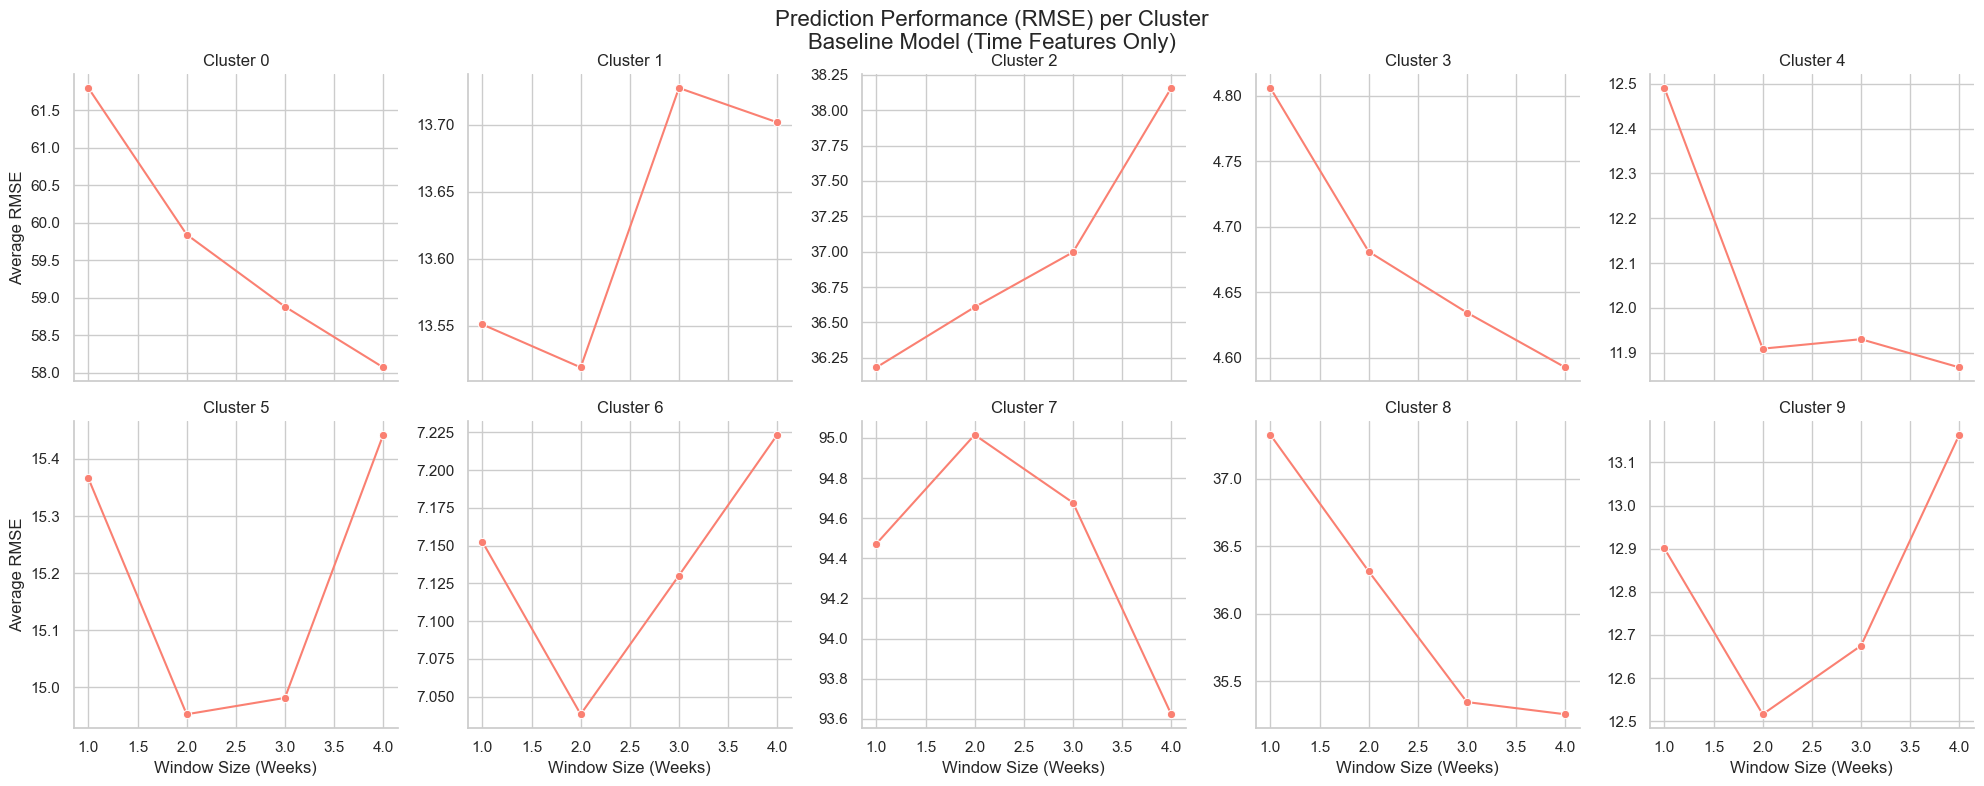

In [52]:
# Convert baseline results to a DataFrame for plotting
records_baseline = []
for cluster, window_dict in results_baseline.items():
    for window, avg_rmse in window_dict.items():
        records_baseline.append({
            "Cluster": cluster,
            "Window_Weeks": window,
            "Avg_RMSE": avg_rmse
        })

results_df_baseline = pd.DataFrame(records_baseline)

# Plot RMSE per cluster for baseline model
sns.set(style="whitegrid")

g = sns.FacetGrid(results_df_baseline, col="Cluster", col_wrap=5, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="Window_Weeks", y="Avg_RMSE", marker="o", color="salmon")

g.set_titles("Cluster {col_name}")
g.set_axis_labels("Window Size (Weeks)", "Average RMSE")
g.fig.suptitle("Prediction Performance (RMSE) per Cluster\nBaseline Model (Time Features Only)", fontsize=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.90)

plt.show()

### Key Findings:
- Prediction quality (RMSE) varied considerably between clusters.
- No consistent improvement was observed with increasing window size.
- In some clusters, shorter windows yielded better results than longer ones.
- There is no universally optimal window size across all clusters.
- Results suggest that window size should be tuned individually per cluster.

## 2. Enhanced Feature Model

- Time-based and lag features are added to enrich the dataset and improve forecasting accuracy.
- Features like dayofweek, is_weekend, lag_1–3, rolling_mean_3, and rolling_std_6 capture temporal patterns and recent demand trends.
- Enhancements are applied consistently across all ten clusters.
- A sliding window approach simulates real-time forecasting using recent history.
- This setup evaluates how enriched features improve demand prediction over time.

In [53]:
def add_time_features(df):
    """
    Adds time-based, holiday (US + NY), and lag-based features to the input DataFrame.
    Assumes a 'messagetimestamp' column (datetime) and 'rides_per_hour' as target.
    """
    df = df.copy()

    # Convert to datetime
    df['messagetimestamp'] = pd.to_datetime(df['messagetimestamp'])

    # Sort for lag correctness
    df = df.sort_values('messagetimestamp')

    # Time-based features
    df['hour'] = df['messagetimestamp'].dt.hour
    df['dayofweek'] = df['messagetimestamp'].dt.dayofweek
    df['month'] = df['messagetimestamp'].dt.month
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

    # US national + NY state holidays
    years = df['messagetimestamp'].dt.year.unique()
    us_ny_holidays = holidays.US(years=years, state='NY')
    df['_is_holiday'] = df['messagetimestamp'].dt.date.isin(us_ny_holidays).astype(int)

    # Lag features
    df['lag_1'] = df['rides_per_hour'].shift(1)
    df['lag_2'] = df['rides_per_hour'].shift(2)
    df['lag_3'] = df['rides_per_hour'].shift(3)

    # Rolling window statistics
    df['rolling_mean_3'] = df['rides_per_hour'].rolling(window=3).mean()
    df['rolling_std_6'] = df['rides_per_hour'].rolling(window=6).std()

    # Remove NaNs from lag/rolling
    df = df.dropna()

    return df

# Apply feature engineering to all clusters named cluster_0 to cluster_9
for i in range(10):
    cluster_name = f"cluster_{i}"
    cluster_df = globals()[cluster_name]
    
    # Apply time feature engineering
    cluster_df = add_time_features(cluster_df)
    
    # Overwrite original cluster variable
    globals()[cluster_name] = cluster_df

In [54]:
cluster_0

,messagetimestamp,rides_per_hour,temperature_c,precipitation_mm,hour,dayofweek,month,is_weekend,_is_holiday,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_6
5,2014-04-01 05:00:00,61,5.6,0.0,5,1,4,0,0,36.0,18.0,12.0,38.333333,18.305737
6,2014-04-01 06:00:00,156,5.0,0.0,6,1,4,0,0,61.0,36.0,18.0,84.333333,55.094162
7,2014-04-01 07:00:00,191,3.3,0.0,7,1,4,0,0,156.0,61.0,36.0,136.000000,75.968414
8,2014-04-01 08:00:00,139,2.8,0.0,8,1,4,0,0,191.0,156.0,61.0,162.000000,71.103915
9,2014-04-01 09:00:00,89,4.4,0.0,9,1,4,0,0,139.0,191.0,156.0,139.666667,59.685844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4386,2014-09-30 18:00:00,594,22.2,0.0,18,1,9,0,0,521.0,430.0,384.0,515.000000,109.190964
4387,2014-09-30 19:00:00,540,22.2,0.0,19,1,9,0,0,594.0,521.0,430.0,551.666667,101.389842
4388,2014-09-30 20:00:00,483,22.2,0.0,20,1,9,0,0,540.0,594.0,521.0,539.000000,76.338719
4389,2014-09-30 21:00:00,431,22.2,0.0,21,1,9,0,0,483.0,540.0,594.0,484.666667,64.539652


In [55]:
def sliding_window_evaluation_enriched(df, window_size_hours=168, forecast_horizon_hours=24):
    """
    Sliding window evaluation using Random Forest on enriched feature set.
    """
    rmse_scores = []
    total_hours = len(df)

    # Define feature set
    features = [
        'hour', 'dayofweek', 'month', 'is_weekend', '_is_holiday',
        'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_6'
    ]

    start = 0
    while start + window_size_hours + forecast_horizon_hours <= total_hours:
        train = df.iloc[start : start + window_size_hours]
        test = df.iloc[start + window_size_hours : start + window_size_hours + forecast_horizon_hours]

        X_train = train[features]
        y_train = train['rides_per_hour']

        X_test = test[features]
        y_test = test['rides_per_hour']

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)

        start += forecast_horizon_hours 

    return np.mean(rmse_scores), rmse_scores

# Define window sizes in weeks (1–4 weeks)
window_sizes_weeks = [1, 2, 3, 4]
forecast_horizon_hours = 24

results_enriched = {}

for i in range(10):
    df = globals()[f"cluster_{i}"]

    print(f"\nEvaluating Cluster {i} with enriched features")
    results_enriched[i] = {}

    for w in window_sizes_weeks:
        window_hours = w * 7 * 24

        if len(df) < window_hours + forecast_horizon_hours:
            print(f"  Cluster {i}, Window {w} weeks: Not enough data, skipping")
            continue

        avg_rmse, _ = sliding_window_evaluation_enriched(
            df,
            window_size_hours=window_hours,
            forecast_horizon_hours=forecast_horizon_hours
        )

        results_enriched[i][w] = avg_rmse
        print(f"  Window {w} week(s): Avg. RMSE = {avg_rmse:.2f}")


Evaluating Cluster 0 with enriched features
  Window 1 week(s): Avg. RMSE = 37.08
  Window 2 week(s): Avg. RMSE = 31.11
  Window 3 week(s): Avg. RMSE = 27.44
  Window 4 week(s): Avg. RMSE = 25.79

Evaluating Cluster 1 with enriched features
  Window 1 week(s): Avg. RMSE = 7.96
  Window 2 week(s): Avg. RMSE = 7.04
  Window 3 week(s): Avg. RMSE = 6.52
  Window 4 week(s): Avg. RMSE = 6.13

Evaluating Cluster 2 with enriched features
  Window 1 week(s): Avg. RMSE = 23.24
  Window 2 week(s): Avg. RMSE = 19.94
  Window 3 week(s): Avg. RMSE = 18.44
  Window 4 week(s): Avg. RMSE = 17.34

Evaluating Cluster 3 with enriched features
  Window 1 week(s): Avg. RMSE = 2.85
  Window 2 week(s): Avg. RMSE = 2.47
  Window 3 week(s): Avg. RMSE = 2.28
  Window 4 week(s): Avg. RMSE = 2.16

Evaluating Cluster 4 with enriched features
  Window 1 week(s): Avg. RMSE = 8.21
  Window 2 week(s): Avg. RMSE = 7.08
  Window 3 week(s): Avg. RMSE = 6.55
  Window 4 week(s): Avg. RMSE = 6.14

Evaluating Cluster 5 with 

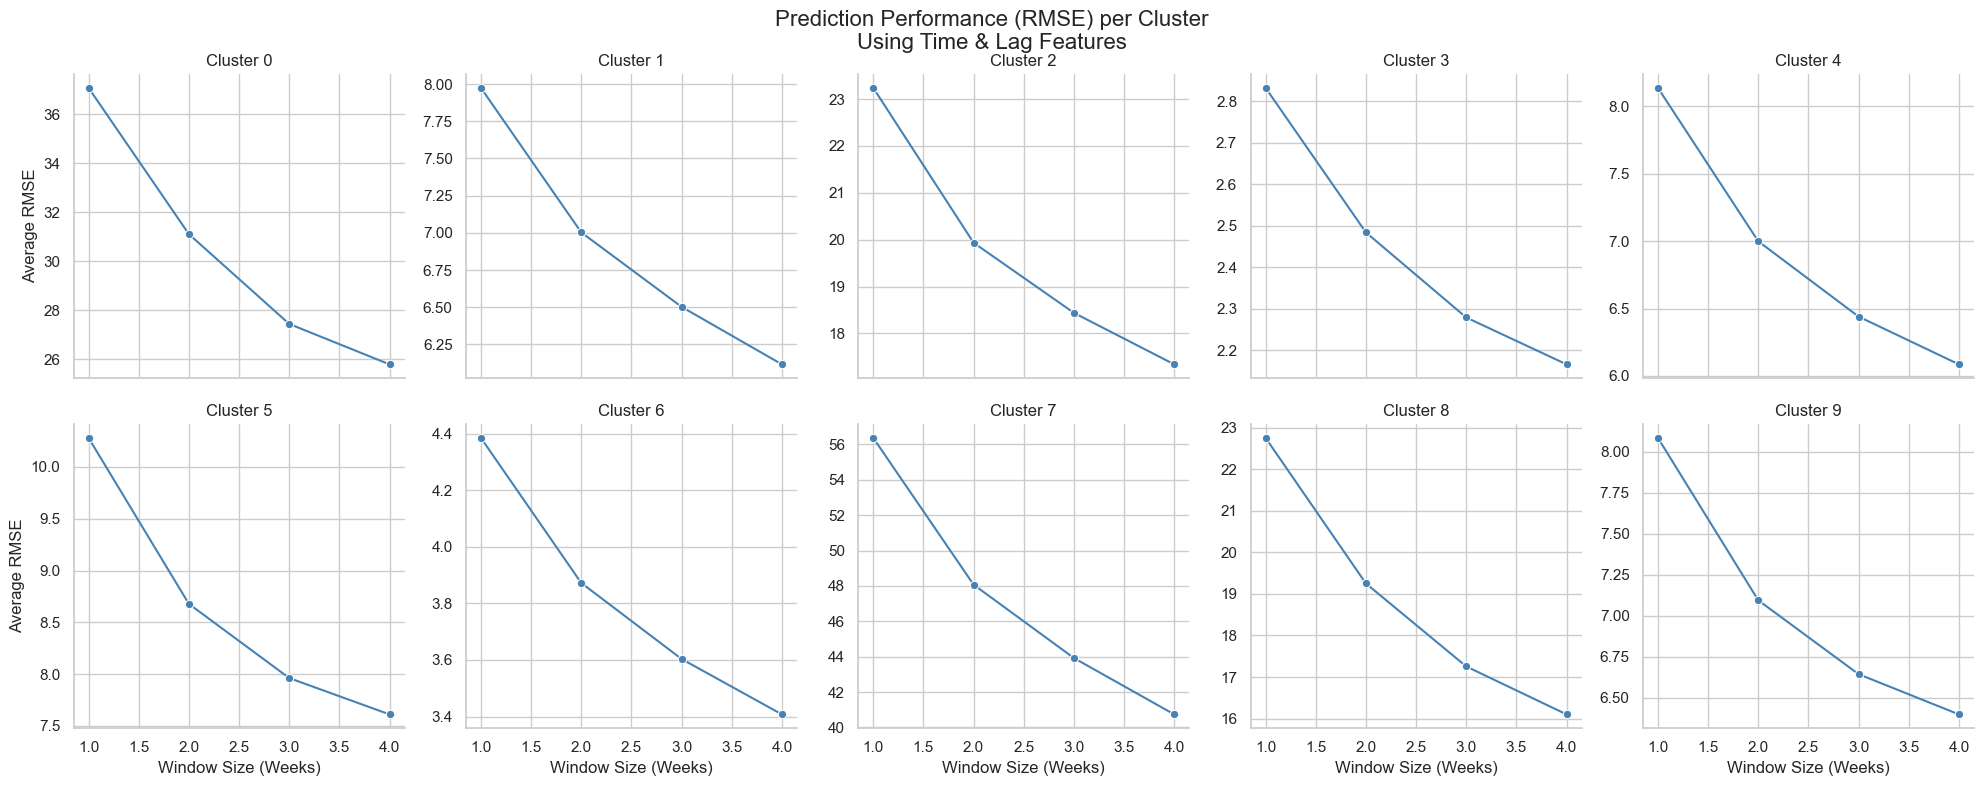

In [17]:
# Convert results to a DataFrame for plotting
records = []
for cluster, window_dict in results_enriched.items():
    for window, avg_rmse in window_dict.items():
        records.append({
            "Cluster": cluster,
            "Window_Weeks": window,
            "Avg_RMSE": avg_rmse
        })

results_df = pd.DataFrame(records)

# Plot RMSE per cluster
sns.set(style="whitegrid")

g = sns.FacetGrid(results_df, col="Cluster", col_wrap=5, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="Window_Weeks", y="Avg_RMSE", marker="o", color="steelblue")

g.set_titles("Cluster {col_name}")
g.set_axis_labels("Window Size (Weeks)", "Average RMSE")
g.fig.suptitle("Prediction Performance (RMSE) per Cluster\nUsing Time & Lag Features", fontsize=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.90)

plt.show()


### Key Findings: 
- The plots display the RSME values fot the 10 clusters using different lag window sizes (1 to 4 weeks).
- RSME decresases in all 10 clusters consistently as the window size increases.
- This indicates, that longer historical input inproves prediction accuracy.
- Each cluster has different RSME leels, reflecting varying levels of preditability
- The trend is uniformly downward, showing stable improvement across clusters. 
- No overfitting is obsered, even at the largest window size. 
- A four week lag window appears to be a reliable and effective choice for all clusters.

## 3. Adding the weather Features 

- In the following step, weather variables such as temperature and precipitation are added to the feature set to assess their contribution to predictive performance.
- The same sliding window approach is applied, using a moving training window to simulate real-time forecasting under realistic conditions.
- This evaluation helps determine whether environmental factors enhance the model’s ability to explain and predict variations in ride demand.

In [56]:
def sliding_window_evaluation_weather_enriched(df, window_size_hours=168, forecast_horizon_hours=24):
    """
    Sliding window evaluation using Random Forest on enriched feature set
    including weather data.
    """
    rmse_scores = []
    total_hours = len(df)

    # Define enriched feature set including weather
    features = [
        'hour', 'dayofweek', 'month', 'is_weekend', '_is_holiday',
        'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_6',
        'temperature_c', 'precipitation_mm'
    ]

    start = 0
    while start + window_size_hours + forecast_horizon_hours <= total_hours:
        train = df.iloc[start : start + window_size_hours]
        test = df.iloc[start + window_size_hours : start + window_size_hours + forecast_horizon_hours]

        X_train = train[features]
        y_train = train['rides_per_hour']

        X_test = test[features]
        y_test = test['rides_per_hour']

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)

        start += forecast_horizon_hours 

    return np.mean(rmse_scores), rmse_scores

# Define window sizes in weeks
window_sizes_weeks = [1, 2, 3, 4]
forecast_horizon_hours = 24

results_weather_enriched = {}

for i in range(10):
    df = globals()[f"cluster_{i}"]

    print(f"\nEvaluating Cluster {i} with weather-enriched features")
    results_weather_enriched[i] = {}

    for w in window_sizes_weeks:
        window_hours = w * 7 * 24

        if len(df) < window_hours + forecast_horizon_hours:
            print(f"  Cluster {i}, Window {w} weeks: Not enough data, skipping")
            continue

        avg_rmse, _ = sliding_window_evaluation_weather_enriched(
            df,
            window_size_hours=window_hours,
            forecast_horizon_hours=forecast_horizon_hours
        )

        results_weather_enriched[i][w] = avg_rmse
        print(f"  Window {w} week(s): Avg. RMSE = {avg_rmse:.2f}")


Evaluating Cluster 0 with weather-enriched features
  Window 1 week(s): Avg. RMSE = 37.91
  Window 2 week(s): Avg. RMSE = 31.74
  Window 3 week(s): Avg. RMSE = 28.02
  Window 4 week(s): Avg. RMSE = 26.24

Evaluating Cluster 1 with weather-enriched features
  Window 1 week(s): Avg. RMSE = 8.10
  Window 2 week(s): Avg. RMSE = 7.14
  Window 3 week(s): Avg. RMSE = 6.63
  Window 4 week(s): Avg. RMSE = 6.25

Evaluating Cluster 2 with weather-enriched features
  Window 1 week(s): Avg. RMSE = 23.78
  Window 2 week(s): Avg. RMSE = 20.40
  Window 3 week(s): Avg. RMSE = 18.96
  Window 4 week(s): Avg. RMSE = 17.76

Evaluating Cluster 3 with weather-enriched features
  Window 1 week(s): Avg. RMSE = 2.91
  Window 2 week(s): Avg. RMSE = 2.54
  Window 3 week(s): Avg. RMSE = 2.35
  Window 4 week(s): Avg. RMSE = 2.21

Evaluating Cluster 4 with weather-enriched features
  Window 1 week(s): Avg. RMSE = 8.41
  Window 2 week(s): Avg. RMSE = 7.23
  Window 3 week(s): Avg. RMSE = 6.67
  Window 4 week(s): Avg.

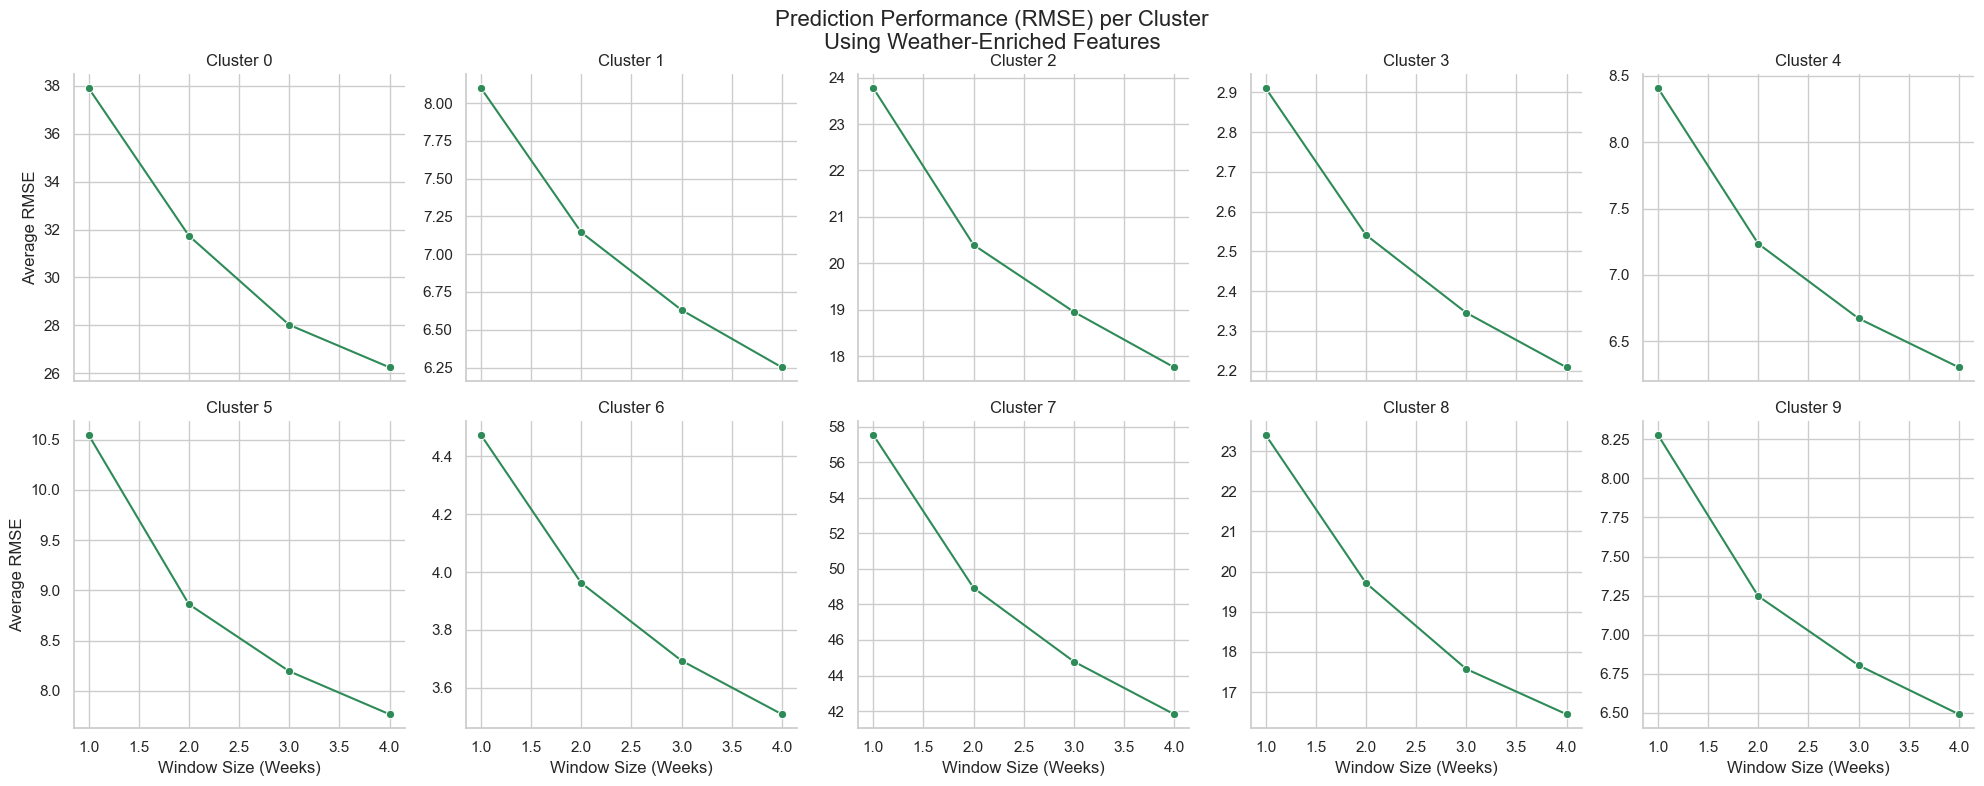

In [58]:
# Convert results to a DataFrame for plotting
records_weather = []
for cluster, window_dict in results_weather_enriched.items():
    for window, avg_rmse in window_dict.items():
        records_weather.append({
            "Cluster": cluster,
            "Window_Weeks": window,
            "Avg_RMSE": avg_rmse
        })

results_weather_df = pd.DataFrame(records_weather)

# Plot RMSE per cluster for weather-enriched model
sns.set(style="whitegrid")

g = sns.FacetGrid(results_weather_df, col="Cluster", col_wrap=5, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="Window_Weeks", y="Avg_RMSE", marker="o", color="seagreen")

g.set_titles("Cluster {col_name}")
g.set_axis_labels("Window Size (Weeks)", "Average RMSE")
g.fig.suptitle("Prediction Performance (RMSE) per Cluster\nUsing Weather-Enriched Features", fontsize=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.90)

plt.show()

## 4. Comparison of the Baseline Model and the Model with the Enhanced Features

- Pre-trained Random Forest models are loaded per cluster.
- Predictions are made for the next 24 hours using recent data.
- RMSE and daily demand error are calculated to evaluate performance.
- Results are summarized and visualized to assess accuracy.

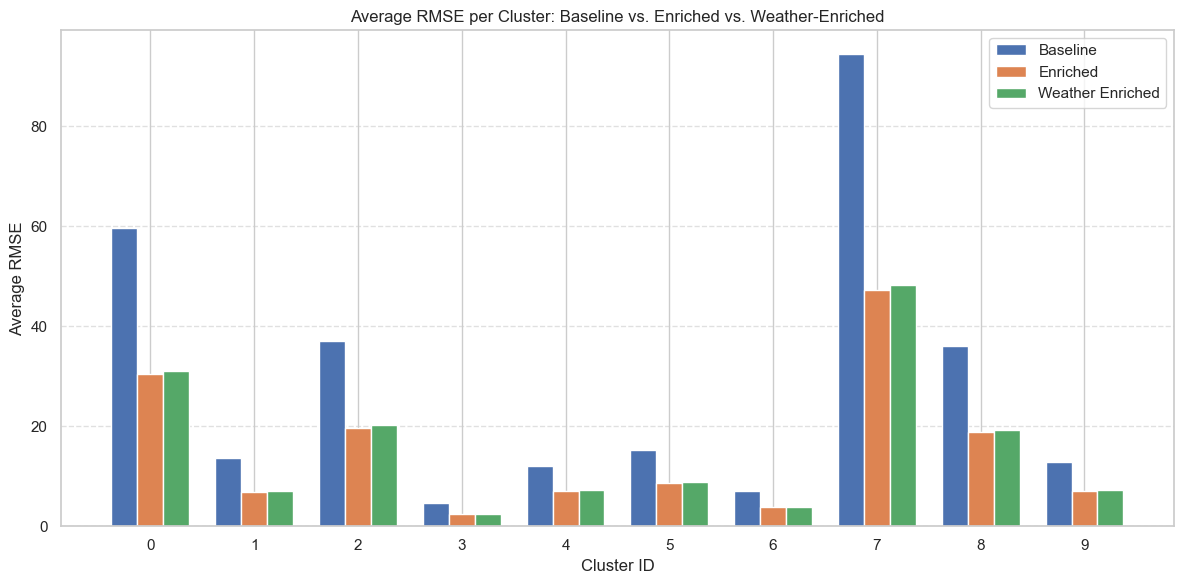

In [59]:
# Prepare lists for plotting
clusters = sorted(results_baseline.keys())
baseline_avgs = []
enriched_avgs = []
weather_enriched_avgs = []

# Compute average RMSEs over all window sizes
for cluster_id in clusters:
    baseline_vals = list(results_baseline[cluster_id].values())
    enriched_vals = list(results_enriched.get(cluster_id, {}).values())
    weather_vals = list(results_weather_enriched.get(cluster_id, {}).values())

    baseline_avg = np.mean(baseline_vals)
    enriched_avg = np.mean(enriched_vals) if enriched_vals else np.nan
    weather_avg = np.mean(weather_vals) if weather_vals else np.nan

    baseline_avgs.append(baseline_avg)
    enriched_avgs.append(enriched_avg)
    weather_enriched_avgs.append(weather_avg)

# Plot
x = np.arange(len(clusters))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, baseline_avgs, width, label='Baseline')
plt.bar(x, enriched_avgs, width, label='Enriched')
plt.bar(x + width, weather_enriched_avgs, width, label='Weather Enriched')

plt.xlabel('Cluster ID')
plt.ylabel('Average RMSE')
plt.title('Average RMSE per Cluster: Baseline vs. Enriched vs. Weather-Enriched')
plt.xticks(x, clusters)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [64]:
# Create a DataFrame with all three results
rmse_comparison_df = pd.DataFrame({
    "Cluster": clusters,
    "Baseline_Avg_RMSE": np.round(baseline_avgs, 2),
    "Enriched_Avg_RMSE": np.round(enriched_avgs, 2),
    "Weather_Enriched_Avg_RMSE": np.round(weather_enriched_avgs, 2)
})

# Percentage improvement: Baseline → Enriched
rmse_comparison_df["Improvement_Baseline_to_Enriched_%"] = (
    100 * (rmse_comparison_df["Baseline_Avg_RMSE"] - rmse_comparison_df["Enriched_Avg_RMSE"])
    / rmse_comparison_df["Baseline_Avg_RMSE"]
).round(2)

# Percentage improvement: Enriched → Weather Enriched
rmse_comparison_df["Improvement_Enriched_to_Weather_%"] = (
    100 * (rmse_comparison_df["Enriched_Avg_RMSE"] - rmse_comparison_df["Weather_Enriched_Avg_RMSE"])
    / rmse_comparison_df["Enriched_Avg_RMSE"]
).round(2)

# Display the table
rmse_comparison_df

,Cluster,Baseline_Avg_RMSE,Enriched_Avg_RMSE,Weather_Enriched_Avg_RMSE,Improvement_Baseline_to_Enriched_%,Improvement_Enriched_to_Weather_%
0,0,59.65,30.35,30.98,49.12,-2.08
1,1,13.62,6.91,7.03,49.27,-1.74
2,2,36.99,19.74,20.22,46.63,-2.43
3,3,4.68,2.44,2.50,47.86,-2.46
4,4,12.05,7.00,7.15,41.91,-2.14
5,5,15.19,8.65,8.84,43.05,-2.20
6,6,7.14,3.83,3.91,46.36,-2.09
7,7,94.45,47.28,48.27,49.94,-2.09
8,8,36.06,18.84,19.29,47.75,-2.39
9,9,12.81,7.06,7.20,44.89,-1.98


In [174]:
rmse_comparison_df['Improvement_Enriched_to_Weather_%'].mean()

np.float64(-2.16)

### Key Findings:
- Using enriched features consistently reduces RMSE across all clusters compared to the baseline.
- The improvement from Baseline to Enriched features is substantial, roughly between 41% and 50% RMSE reduction.
- Clusters 0 and 7 show the largest improvements with about 49–50% reduction in RMSE.
- Clusters 3 and 6 achieve the lowest absolute RMSE values with enriched features (2.44 and 3.83), indicating the best prediction accuracy.
- The baseline model, which only uses “hour” and “dayofweek” features, is insufficient to capture the data dynamics well.
- Incorporating enriched features significantly enhances forecast precision.
- Interestingly, adding weather features (Weather-Enriched Model) slightly degrades performance in all clusters (around 2% higher RMSE compared to Enriched features alone), suggesting these weather features might not contribute positively in this setup.

## 5. Model Training and 24-hour Demand Forecasting with Enriched Time and Lag Features

- Trains the final Random Forest model using the most recent 4 weeks of data for each cluster
- Incorporates comprehensive time-based and lag features to maximize prediction accuracy
- Performs one-step ahead forecasting for the next 24 hours
- Evaluates model performance on this unseen test period using RMSE
- Visualizes and compares predicted vs. actual values to validate forecast quality
- Stores predictions and error metrics as a basis for further evaluation or deployment

Cluster 0 - TEST RMSE: 24.02, Test Daily Demand Error: 0.31%
Cluster 0 - TRAIN RMSE: 11.50, Train Demand Error: 0.08%



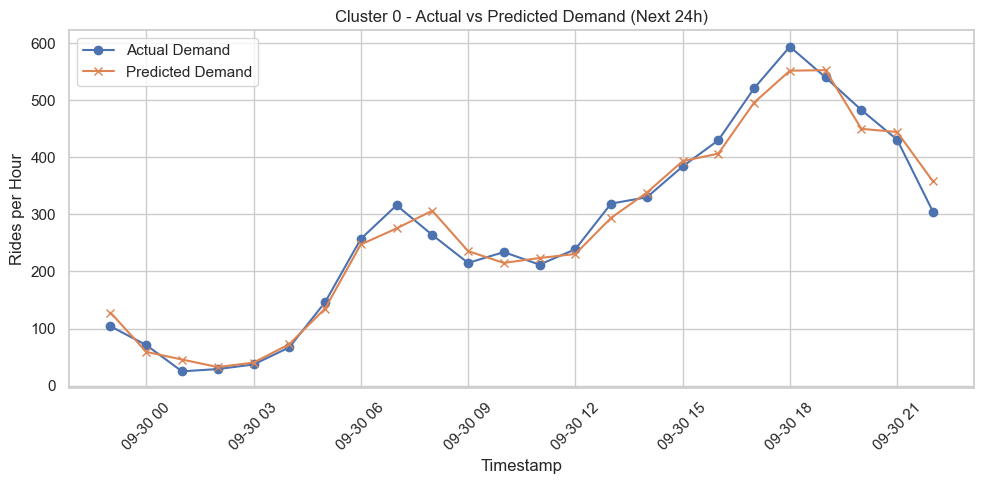

Cluster 1 - TEST RMSE: 5.59, Test Daily Demand Error: 0.42%
Cluster 1 - TRAIN RMSE: 3.33, Train Demand Error: 0.28%



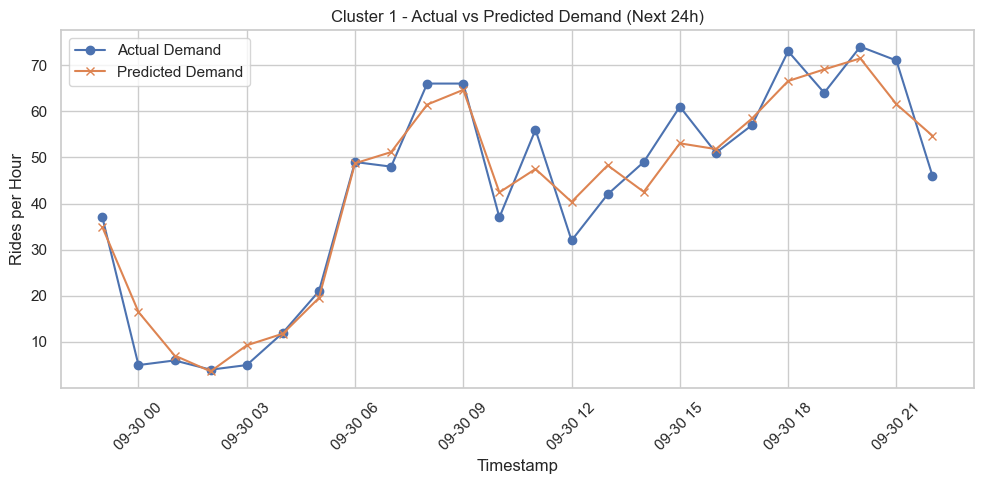

Cluster 2 - TEST RMSE: 30.14, Test Daily Demand Error: 2.31%
Cluster 2 - TRAIN RMSE: 8.37, Train Demand Error: 0.03%



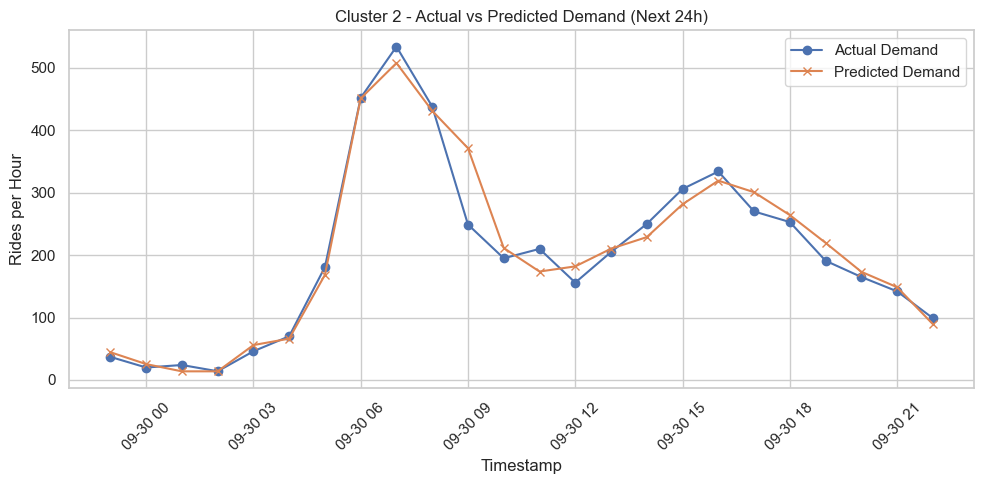

Cluster 3 - TEST RMSE: 2.03, Test Daily Demand Error: 0.36%
Cluster 3 - TRAIN RMSE: 1.06, Train Demand Error: 0.23%



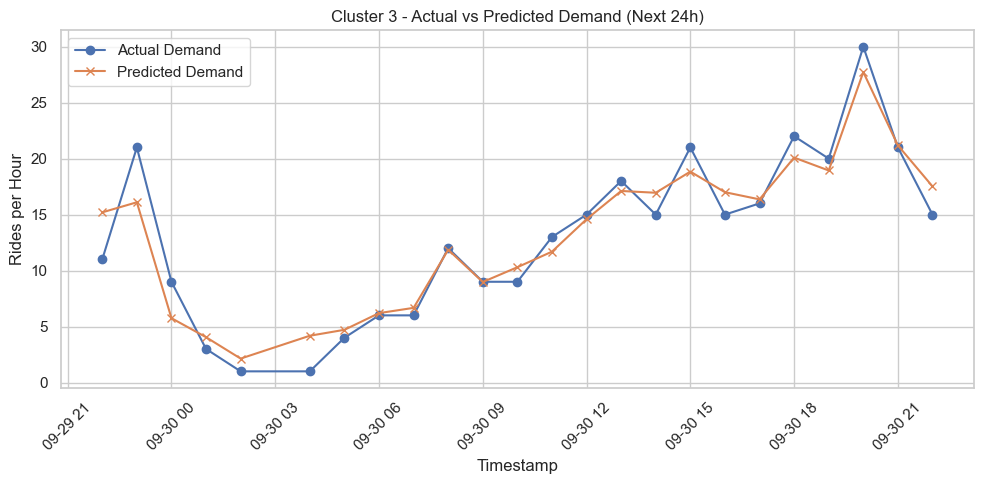

Cluster 4 - TEST RMSE: 5.22, Test Daily Demand Error: 0.46%
Cluster 4 - TRAIN RMSE: 3.14, Train Demand Error: 0.24%



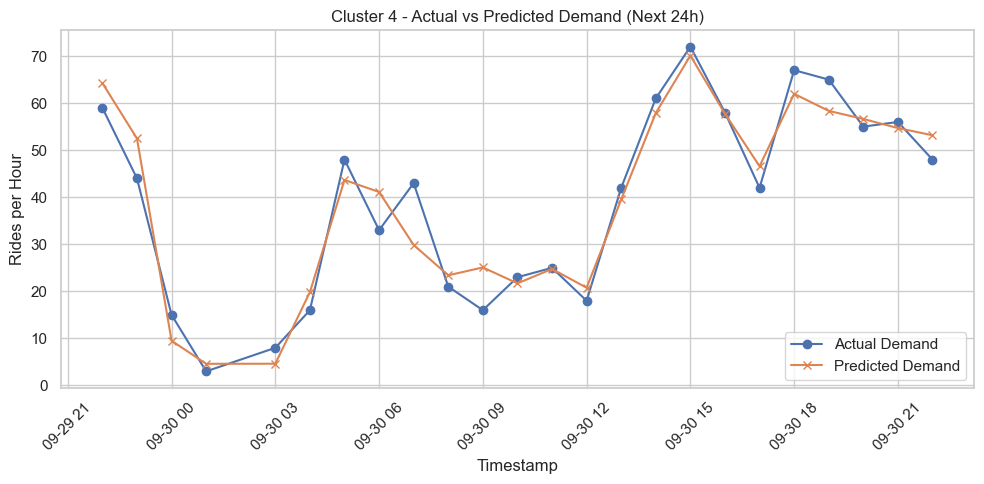

Cluster 5 - TEST RMSE: 6.18, Test Daily Demand Error: 0.28%
Cluster 5 - TRAIN RMSE: 3.61, Train Demand Error: 0.12%



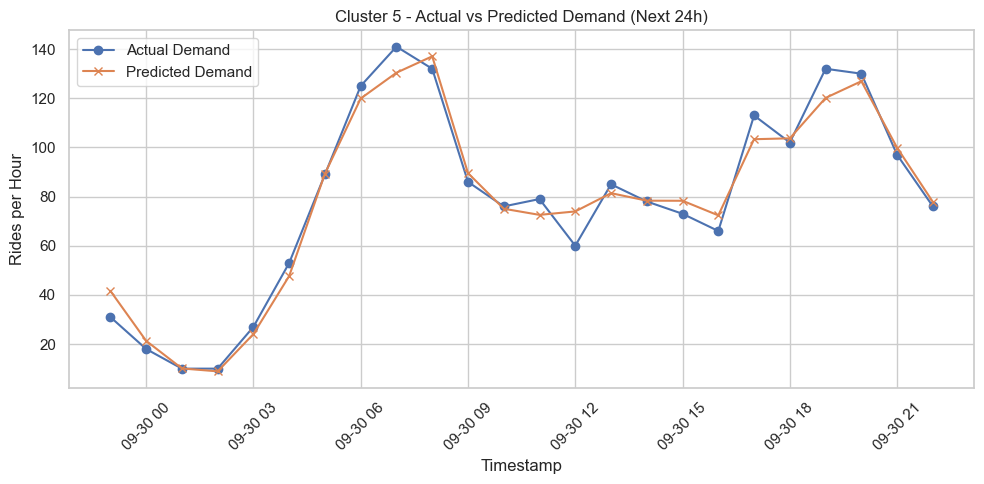

Cluster 6 - TEST RMSE: 2.59, Test Daily Demand Error: 0.69%
Cluster 6 - TRAIN RMSE: 1.70, Train Demand Error: 0.07%



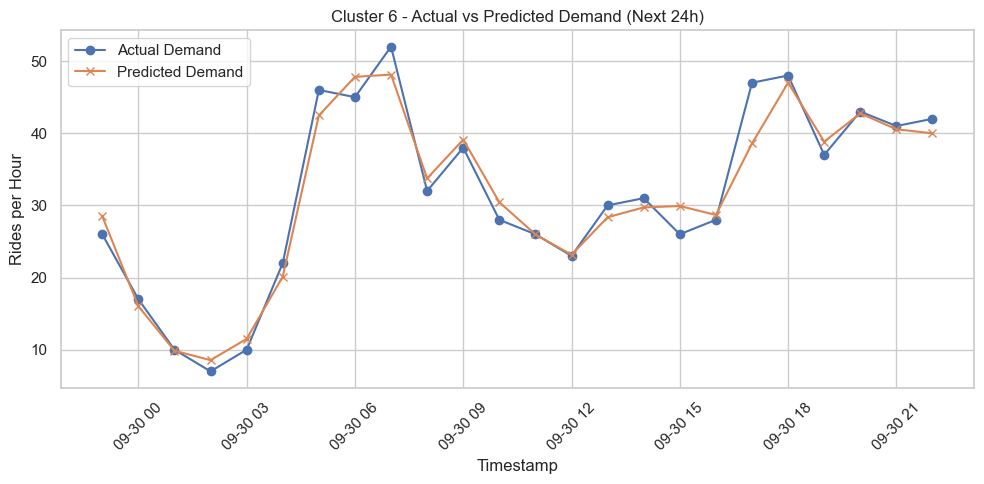

Cluster 7 - TEST RMSE: 42.21, Test Daily Demand Error: 1.00%
Cluster 7 - TRAIN RMSE: 17.46, Train Demand Error: 0.12%



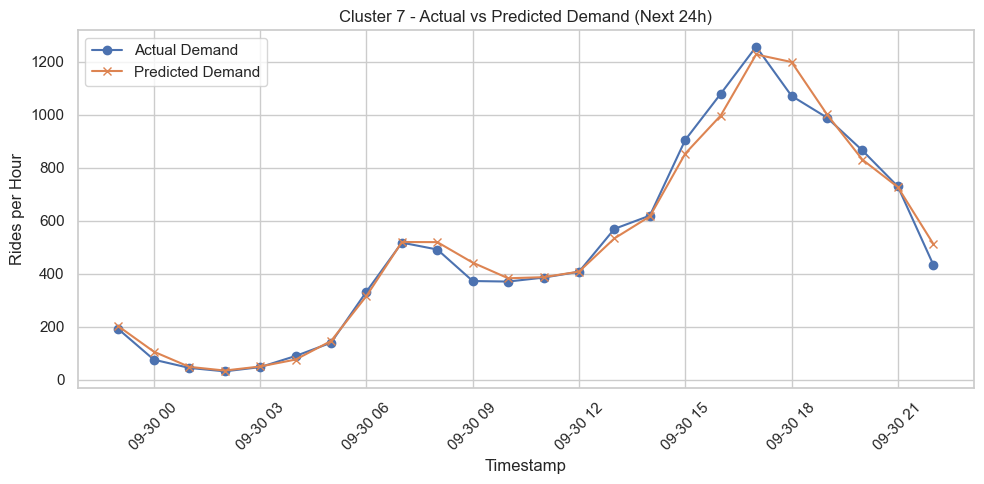

Cluster 8 - TEST RMSE: 19.26, Test Daily Demand Error: 3.50%
Cluster 8 - TRAIN RMSE: 9.59, Train Demand Error: 0.13%



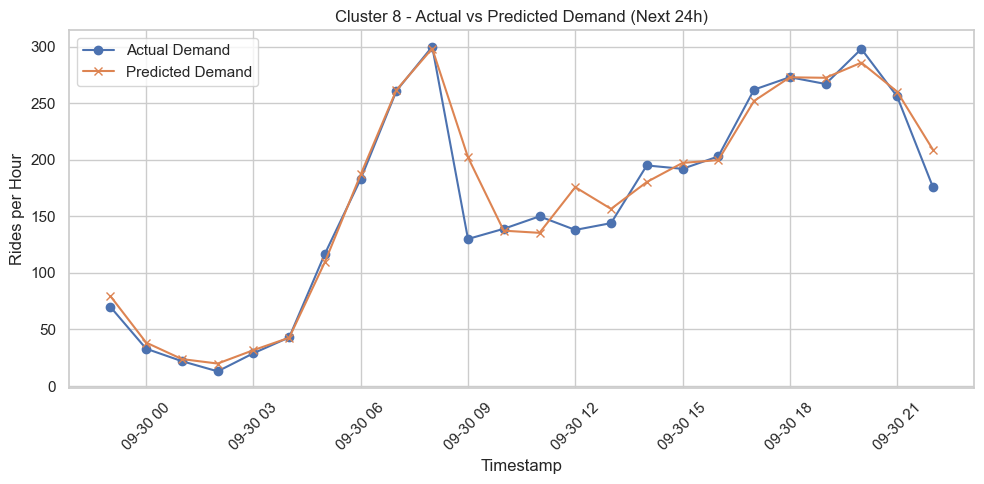

Cluster 9 - TEST RMSE: 5.67, Test Daily Demand Error: 0.07%
Cluster 9 - TRAIN RMSE: 3.21, Train Demand Error: 0.09%



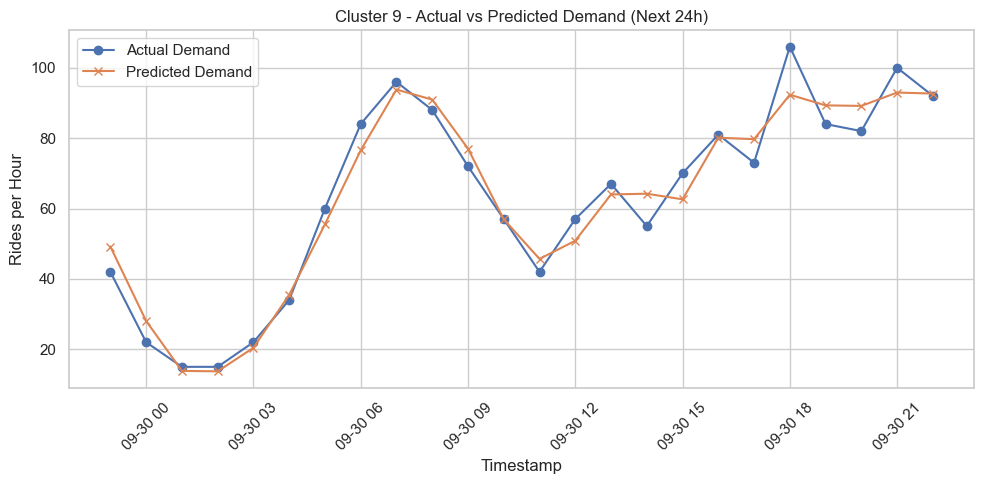


Summary of RMSE and Daily Demand Percentage Error per Cluster:


,Cluster,Test_RMSE,Test_Daily_Demand_Error_%,Train_RMSE,Train_Daily_Demand_Error_%
0,0,24.02,0.31,11.50,0.08
1,1,5.59,0.42,3.33,0.28
2,2,30.14,2.31,8.37,0.03
3,3,2.03,0.36,1.06,0.23
4,4,5.22,0.46,3.14,0.24
5,5,6.18,0.28,3.61,0.12
6,6,2.59,0.69,1.70,0.07
7,7,42.21,1.00,17.46,0.12
8,8,19.26,3.50,9.59,0.13
9,9,5.67,0.07,3.21,0.09


In [100]:
# Features used for training
feature_cols = ['hour', 'dayofweek', 'month', 'is_weekend', '_is_holiday', 
                'lag_1', 'lag_2', 'lag_3',
                'rolling_mean_3', 'rolling_std_6']

# Setting the training window size to 4 weeks
window_size_hours = 4 * 7 * 24 

# Setting the forecast horizon to 24 hours
forecast_horizon_hours = 24     

# Containers for results
all_predictions = {}
all_rmses_test = {}
all_pct_errors_test = {}
all_rmses_train = {}
all_pct_errors_train = {}

for i in range(10):
    cluster_df = globals()[f'cluster_{i}']
    
    if len(cluster_df) < window_size_hours + forecast_horizon_hours:
        print(f"Cluster {i} does not have enough data for forecasting.")
        continue
    
    # Define training and test sets
    train = cluster_df.iloc[-(window_size_hours + forecast_horizon_hours):-forecast_horizon_hours]
    test = cluster_df.iloc[-forecast_horizon_hours:]
    
    X_train = train[feature_cols]
    y_train = train['rides_per_hour']
    
    X_test = test[feature_cols]
    y_test = test['rides_per_hour']
    
    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on test
    y_pred_test = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    total_actual_test = y_test.sum()
    total_pred_test = y_pred_test.sum()
    pct_error_test = abs(total_actual_test - total_pred_test) / total_actual_test * 100 if total_actual_test > 0 else np.nan

    # Predict on train
    y_pred_train = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    total_actual_train = y_train.sum()
    total_pred_train = y_pred_train.sum()
    pct_error_train = abs(total_actual_train - total_pred_train) / total_actual_train * 100 if total_actual_train > 0 else np.nan

    print(f"Cluster {i} - TEST RMSE: {rmse_test:.2f}, Test Daily Demand Error: {pct_error_test:.2f}%")
    print(f"Cluster {i} - TRAIN RMSE: {rmse_train:.2f}, Train Demand Error: {pct_error_train:.2f}%\n")
    
    # Save results
    preds_df = test[['messagetimestamp']].copy()
    preds_df['predicted_rides_per_hour'] = y_pred_test
    preds_df['actual_rides_per_hour'] = y_test.values
    preds_df['rmse_test'] = rmse_test
    preds_df['pct_error_test'] = pct_error_test
    all_predictions[i] = preds_df

    all_rmses_test[i] = rmse_test
    all_pct_errors_test[i] = pct_error_test
    all_rmses_train[i] = rmse_train
    all_pct_errors_train[i] = pct_error_train

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(test['messagetimestamp'], y_test, label='Actual Demand', marker='o')
    plt.plot(test['messagetimestamp'], y_pred_test, label='Predicted Demand', marker='x')
    plt.title(f'Cluster {i} - Actual vs Predicted Demand (Next 24h)')
    plt.xlabel('Timestamp')
    plt.ylabel('Rides per Hour')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Summary DataFrame
summary_df = pd.DataFrame({
    'Cluster': list(all_rmses_test.keys()),
    'Test_RMSE': list(all_rmses_test.values()),
    'Test_Daily_Demand_Error_%': list(all_pct_errors_test.values()),
    'Train_RMSE': list(all_rmses_train.values()),
    'Train_Daily_Demand_Error_%': list(all_pct_errors_train.values())
})

# Round for readability
summary_df = summary_df.round(2)

print("\nSummary of RMSE and Daily Demand Percentage Error per Cluster:")
summary_df

### Key Findings:
- Cluster 3 achieved the lowest test RMSE (2.03) and low test error (0.36%).
- Cluster 7 had the highest test RMSE (42.21), indicating more volatile or unpredictable demand.
- Most clusters had test RMSEs below 10, suggesting generally good forecasting accuracy.
- Percentage test errors were low across clusters (mostly <1%), except Cluster 8 (3.5%) and Cluster 2 (2.31%).
- Training errors were very low throughout, often below 0.2%, confirming good model fit.
- The overall results show that short-term demand can be predicted accurately for most clusters, with only a few showing elevated variance.

## 6. Grid Seach to find the best Combination of Hyperparameters for each cluster

- Since some clusters (e.g., Cluster 2 and 7) still show relatively high test RMSE, further fine-tuning is required to improve model accuracy.
- A Random Forest Regressor is used to model hourly ride demand for each cluster.
- An expanded hyperparameter grid is defined to explore a wider range of model configurations.
- TimeSeriesSplit is applied to ensure proper cross-validation for time-dependent data.
- A GridSearchCV is used to identify the best combination of hyperparameters per cluster.
- The tuning is performed separately for each cluster to account for their individual patterns.
- The best model is chosen based on the lowest negative RMSE score from cross-validation.

In [118]:
# Deleting the weather features since they don't improve the model

weather_features = ['temperature_c', 'precipitation_mm']

for i in range(10):
    cluster_df = globals()[f'cluster_{i}']
    cluster_df = cluster_df.drop(columns=weather_features, errors='ignore')
    globals()[f'cluster_{i}'] = cluster_df

In [146]:
# List with the 10 cluster DataFrames
clusters = [cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, 
            cluster_5, cluster_6, cluster_7, cluster_8, cluster_9]

# Set model save directory (adjust if needed)
model_save_dir = '/Users/sandragedig/Documents/Dokumente/Data_Science/Semester_6/Model_Engineering_Case_Study/public_transport_forecast/models'
os.makedirs(model_save_dir, exist_ok=True)

# Parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# TimeSeriesSplit for CV
tscv = TimeSeriesSplit(n_splits=5)

# Forecast horizon (exclude last 24 hours)
forecast_horizon_hours = 24
window_length = timedelta(weeks=4)

for i, df in enumerate(clusters):
    print(f"\nProcessing Cluster {i}")
    
    df = df.sort_values('messagetimestamp').reset_index(drop=True)

    # Ensure enough data
    if len(df) <= forecast_horizon_hours:
        print(f"Cluster {i} does not have enough data to exclude last 24 hours.")
        continue

    # Define cutoff times
    last_timestamp = df['messagetimestamp'].max()
    train_end_time = last_timestamp - timedelta(hours=forecast_horizon_hours)
    train_start_time = train_end_time - window_length

    # Filter training data: only the last 4 weeks before forecast
    train_df = df[(df['messagetimestamp'] > train_start_time) & 
                  (df['messagetimestamp'] <= train_end_time)]

    if len(train_df) == 0:
        print(f"Cluster {i} has no data in the 4-week training window.")
        continue

    X_train = train_df.drop(columns=['rides_per_hour', 'messagetimestamp'])
    y_train = train_df['rides_per_hour']

    model = RandomForestRegressor(random_state=42, n_jobs=-1)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"Best RMSE (CV) for Cluster {i}: {-grid_search.best_score_:.3f}")
    print(f"Best Params: {grid_search.best_params_}")

    best_model = grid_search.best_estimator_

    model_path = os.path.join(model_save_dir, f'best_rf_cluster_{i}.joblib')
    joblib.dump(best_model, model_path)
    print(f"Saved best model for cluster {i} to {model_path}")


Processing Cluster 0
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best RMSE (CV) for Cluster 0: 37.593
Best Params: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Saved best model for cluster 0 to /Users/sandragedig/Documents/Dokumente/Data_Science/Semester_6/Model_Engineering_Case_Study/public_transport_forecast/models/best_rf_cluster_0.joblib

Processing Cluster 1
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best RMSE (CV) for Cluster 1: 11.103
Best Params: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Saved best model for cluster 1 to /Users/sandragedig/Documents/Dokumente/Data_Science/Semester_6/Model_Engineering_Case_Study/public_transport_forecast/models/best_rf_cluster_1.joblib

Processing Cluster 2
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best RMSE (CV) f

### Key Findings:

- RMSE values vary significantly:
- Lowest RMSE: Cluster 3 (~3.6) → very high prediction accuracy
- Highest RMSE: Cluster 7 (~51.2) → more difficult to predict or noisier data
- Overall RMSE range: approx. 3.6 to 51.2

#### Consistently optimal hyperparameters:
- n_estimators: usually 200, but Clusters 0,1,2,7,9 used 100, suggesting lighter models are sometimes sufficient.
- max_depth: None (no depth limit on trees)
- max_features: 'sqrt' (consistently preferred)
- min_samples_split: mostly 2 (allowing deep trees)
- min_samples_leaf: 1
- bootstrap: False (no bootstrapping, full sample training)

#### Model behavior:
- Deep, non-bootstrapped trees fit the clustered data well.
- Consistent use of 'sqrt' for max_features supports generalization.
- Reduced number of trees in some clusters may indicate simpler or more regularized patterns in those subsets.

## 7. Model Training and 24-hour Demand Forecasting with optimized Models after Grid Search

The saved Random Forest models for each cluster are loaded and tested using the last four weeks of data to forecast the next 24 hours. Predictions are made on the test set, and performance metrics (RMSE and daily demand error) are calculated. Results are collected and visualized to evaluate the accuracy of the models across clusters. This process validates the models’ forecasting ability on recent data.

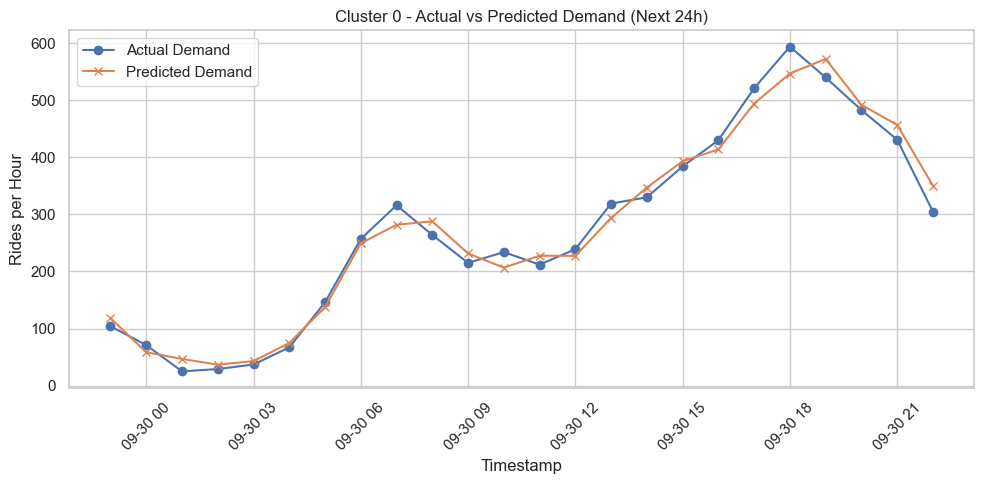

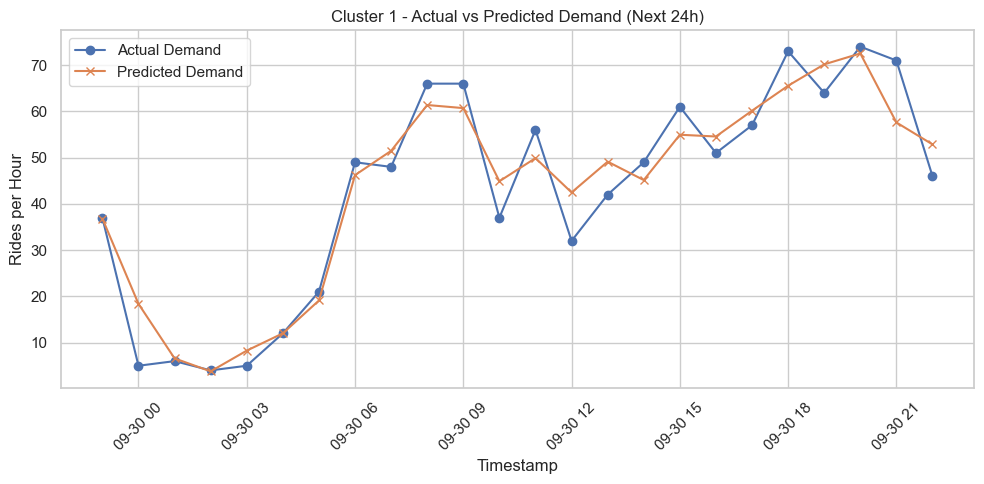

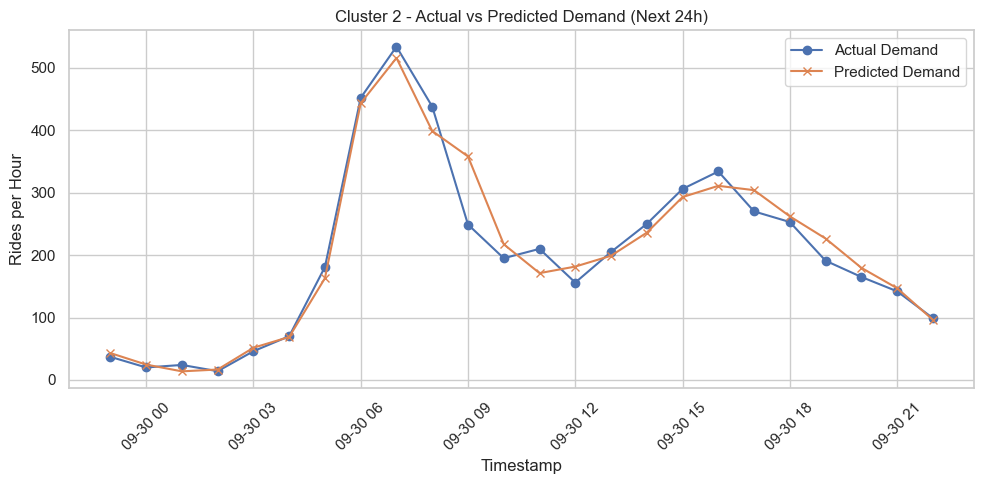

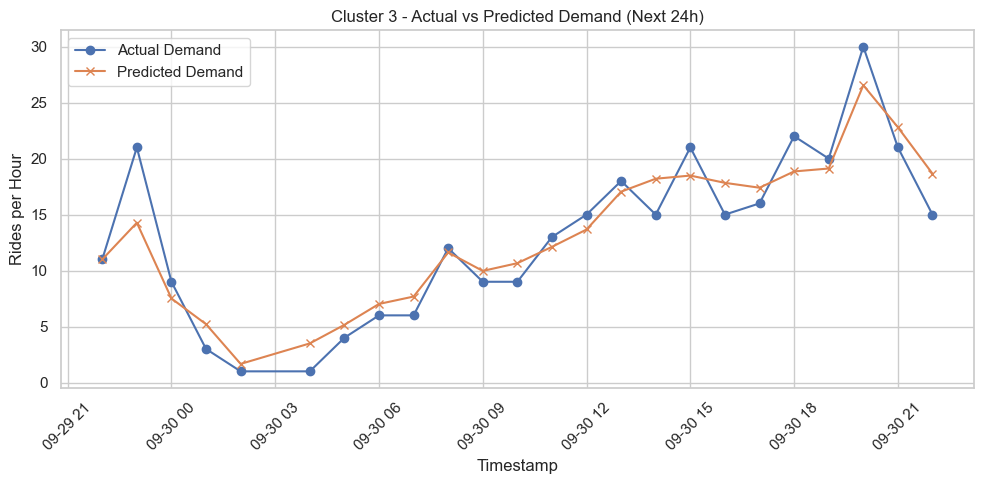

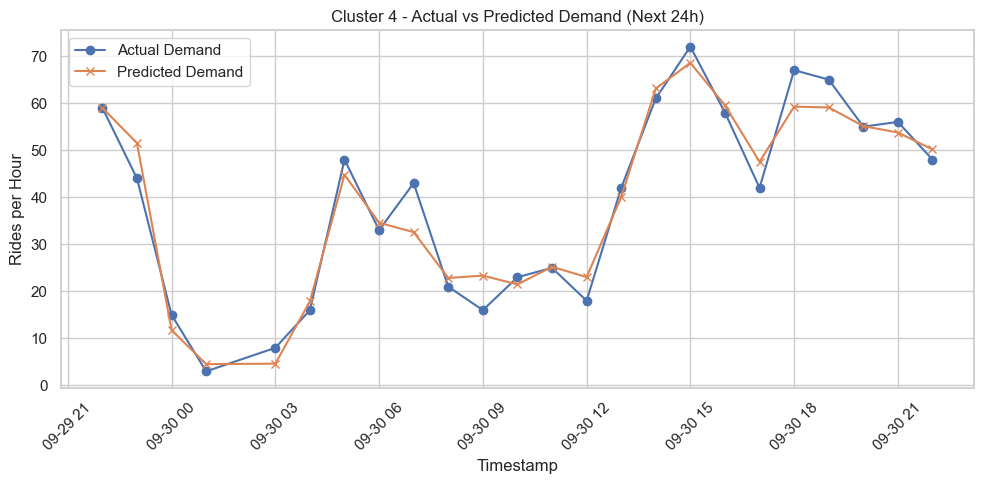

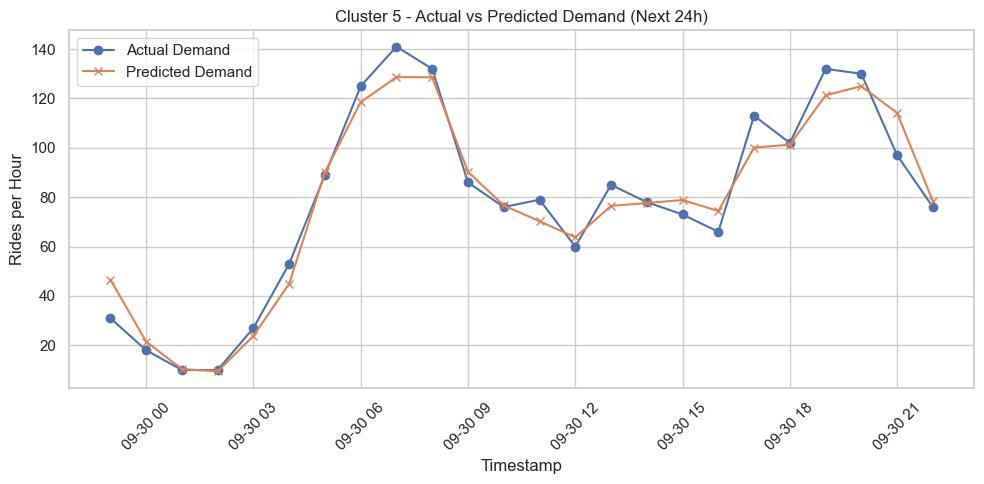

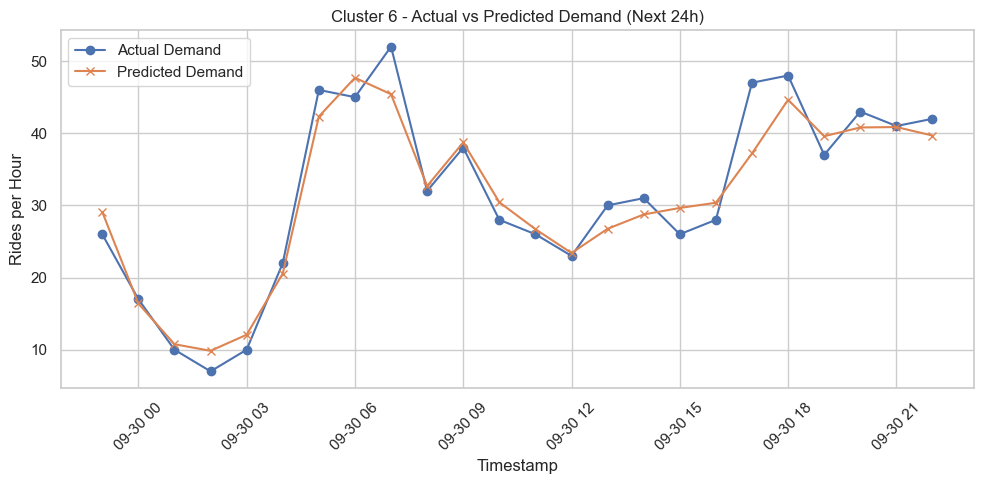

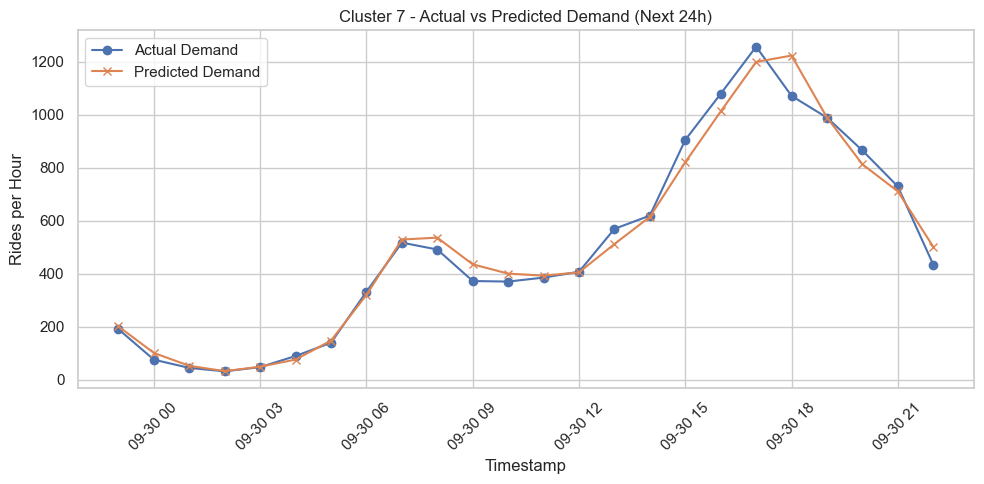

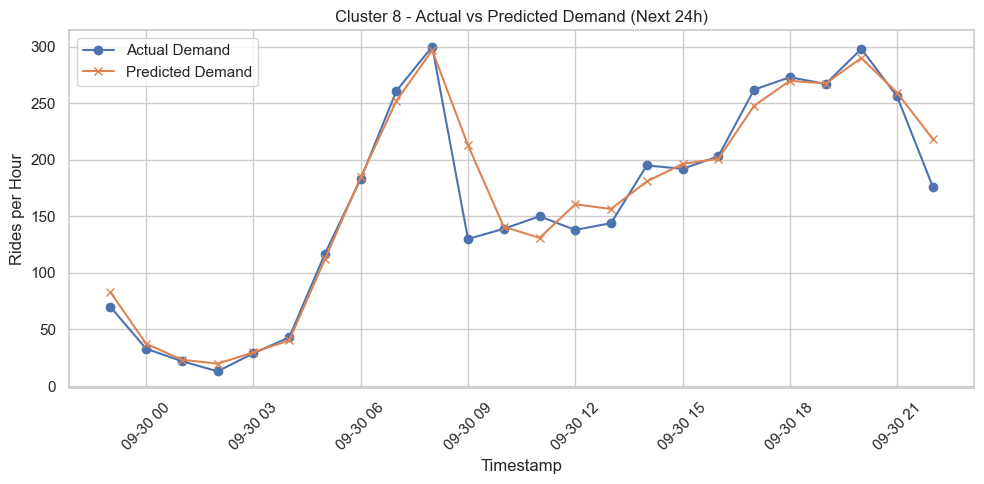

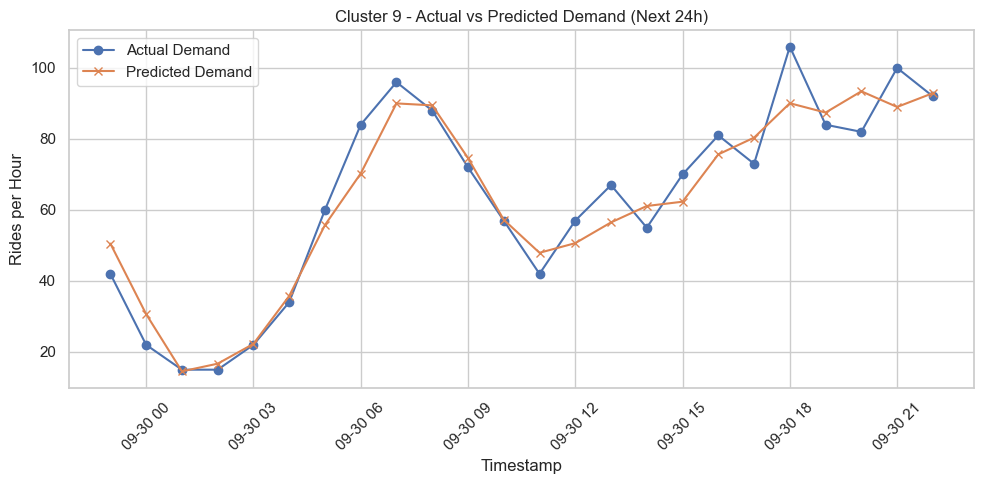

New summary DataFrame with loaded models:


,Cluster,Test_RMSE,Test_Daily_Demand_Error_%
0,0,22.68,0.54
1,1,6.19,1.23
2,2,29.38,1.68
3,3,2.39,0.96
4,4,4.32,0.50
5,5,7.72,0.95
6,6,3.26,1.41
7,7,48.88,0.51
8,8,20.98,3.02
9,9,7.33,1.38


In [147]:
# Defining the feature columns
feature_cols = ['hour', 'dayofweek', 'month', 'is_weekend', '_is_holiday',
                'lag_1', 'lag_2', 'lag_3',
                'rolling_mean_3', 'rolling_std_6']

# Setting the training window to 4 weeks
window_size_hours = 4 * 7 * 24  

# Setting the forecast window to the next 24 hours
forecast_horizon_hours = 24     

all_results = []

for i in range(10):
    cluster_df = globals()[f'cluster_{i}'].copy()

    if len(cluster_df) < window_size_hours + forecast_horizon_hours:
        print(f"Cluster {i} does not have enough data.")
        continue

    # Load the saved model
    model_path = f'/Users/sandragedig/Documents/Dokumente/Data_Science/Semester_6/Model_Engineering_Case_Study/public_transport_forecast/models/best_rf_cluster_{i}.joblib'
    model = joblib.load(model_path)

    # Prepare training and testing slices
    train = cluster_df.iloc[-(window_size_hours + forecast_horizon_hours):-forecast_horizon_hours]
    test = cluster_df.iloc[-forecast_horizon_hours:]

    X_train = train[feature_cols]
    y_train = train['rides_per_hour']

    X_test = test[feature_cols]
    y_test = test['rides_per_hour']

    # Predict on test set with loaded model
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    pct_error_test = abs(y_test.sum() - y_pred_test.sum()) / y_test.sum() * 100 if y_test.sum() > 0 else np.nan

    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    pct_error_train = abs(y_train.sum() - model.predict(X_train).sum()) / y_train.sum() * 100 if y_train.sum() > 0 else np.nan

    # Store results
    all_results.append({
        'Cluster': i,
        'Test_RMSE': rmse_test,
        'Test_Daily_Demand_Error_%': pct_error_test,
    })

    # Plot actual vs predicted demand
    plt.figure(figsize=(10,5))
    plt.plot(test['messagetimestamp'], y_test, label='Actual Demand', marker='o')
    plt.plot(test['messagetimestamp'], y_pred_test, label='Predicted Demand', marker='x')
    plt.title(f'Cluster {i} - Actual vs Predicted Demand (Next 24h)')
    plt.xlabel('Timestamp')
    plt.ylabel('Rides per Hour')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Create DataFrame from results
new_summary_df = pd.DataFrame(all_results).round(2)

print("New summary DataFrame with loaded models:")
new_summary_df


### Key Findings: 
- Clusters 3, 4, and 6 show the best performance, with Test RMSE between 2.39 and 4.32 and daily demand errors below 1%, indicating highly accurate predictions.
- Clusters 1, 5, 6, and 9 have moderate RMSE values (3–8) and daily errors around 1–1.4%, showing acceptable model performance.
- Clusters 0, 2, 7, and 8 have the highest RMSE values (above 20), especially Cluster 7 (RMSE 48.88) and Cluster 2 (RMSE 29.38), suggesting more variability or noise in the data.
- Interestingly, even Cluster 7 has a very low daily error (0.51%), which may imply that large errors occur in short, isolated bursts rather than consistently.
- The highest daily error is found in Cluster 8 (3.02%), which may indicate difficulty in capturing the pattern of overall demand.
- Overall, daily demand errors are low (mostly under 1.5%), showing that the models perform robustly, but some clusters (e.g., 2, 7, 8) still present room for improvement.

## 8. Comparison of the Model with the Enriched Features and the Optimized Grid Search Models

- Both DataFrames are sorted by cluster to ensure correct alignment.
- summary_df contains results from the model with enriched features.
- new_summary_df contains results from the optimized models using Grid Search.
- Bar plots are used to compare Test RMSE and Test Daily Demand Error (%) for each cluster.
- The visual comparison highlights how Grid Search optimization affected performance across clusters.

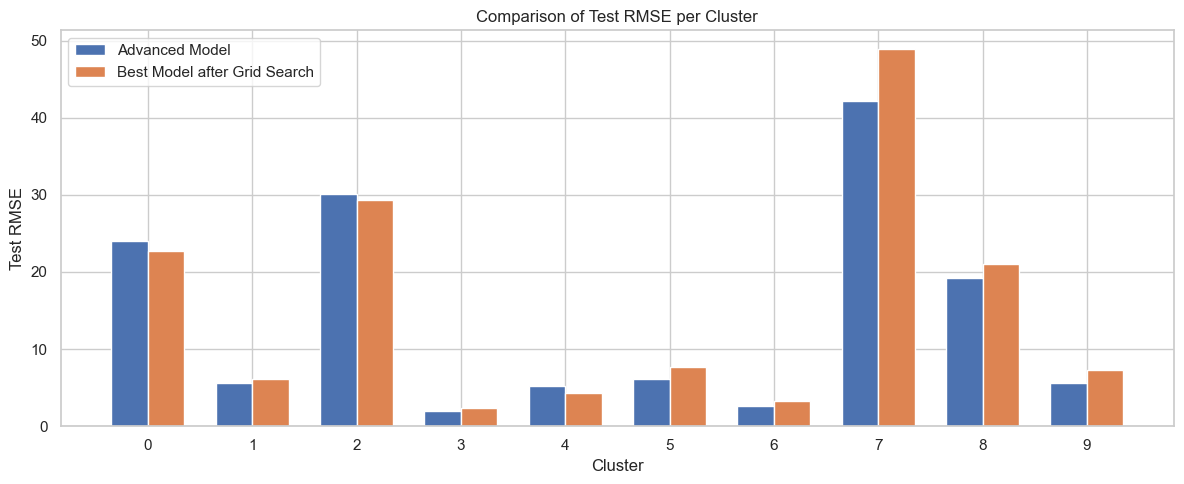

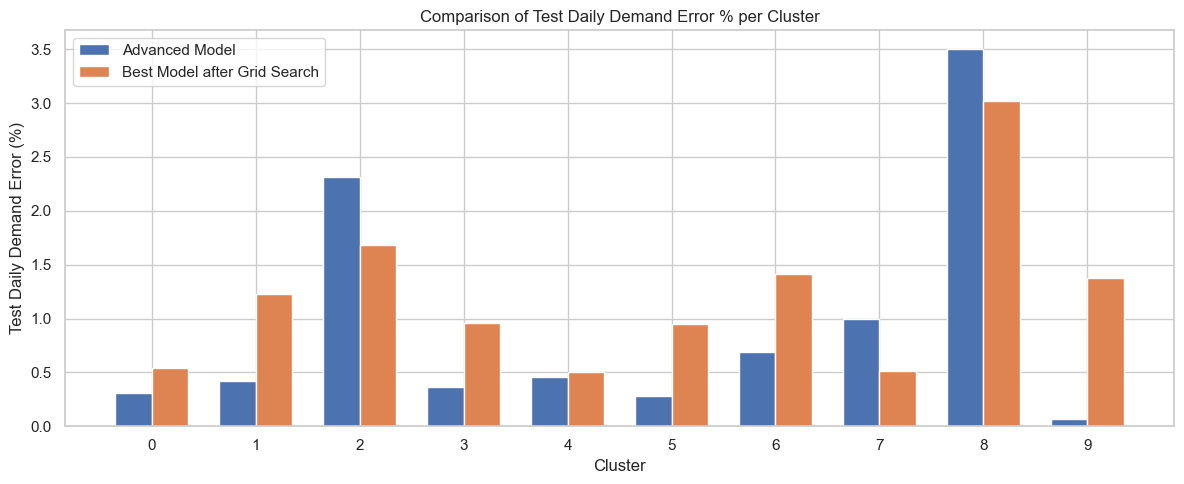

In [149]:
# Make sure both DataFrames are sorted by Cluster
summary_df = summary_df.sort_values('Cluster').reset_index(drop=True)
new_summary_df = new_summary_df.sort_values('Cluster').reset_index(drop=True)

# Plot settings
clusters = summary_df['Cluster']

# Plot Test_RMSE comparison
x = np.arange(len(clusters))
width = 0.35

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, summary_df['Test_RMSE'], width, label='Advanced Model')
plt.bar(x + width/2, new_summary_df['Test_RMSE'], width, label='Best Model after Grid Search')
plt.xticks(x, clusters)
plt.xlabel('Cluster')
plt.ylabel('Test RMSE')
plt.title('Comparison of Test RMSE per Cluster')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Test_Daily_Demand_Error_% comparison
plt.figure(figsize=(12, 5))
plt.bar(x - width/2, summary_df['Test_Daily_Demand_Error_%'], width, label='Advanced Model')
plt.bar(x + width/2, new_summary_df['Test_Daily_Demand_Error_%'], width, label='Best Model after Grid Search')
plt.xticks(x, clusters)
plt.xlabel('Cluster')
plt.ylabel('Test Daily Demand Error (%)')
plt.title('Comparison of Test Daily Demand Error % per Cluster')
plt.legend()
plt.tight_layout()
plt.show()

In [152]:
# Rename columns to distinguish models
summary_df_small = summary_df[['Cluster', 'Test_RMSE', 'Test_Daily_Demand_Error_%']].rename(columns={
    'Test_RMSE': 'Test_RMSE_Advanced',
    'Test_Daily_Demand_Error_%': 'Test_Error_Advanced'
})

new_summary_df_small = new_summary_df[['Cluster', 'Test_RMSE', 'Test_Daily_Demand_Error_%']].rename(columns={
    'Test_RMSE': 'Test_RMSE_GridSearch',
    'Test_Daily_Demand_Error_%': 'Test_Error_GridSearch'
})

# Merge on Cluster
comparison_df = summary_df_small.merge(new_summary_df_small, on='Cluster')

# Function to determine the best model per row
def determine_best_model(row):
    if row['Test_RMSE_Advanced'] < row['Test_RMSE_GridSearch']:
        return 'Advanced'
    elif row['Test_RMSE_GridSearch'] < row['Test_RMSE_Advanced']:
        return 'GridSearch'
    else:
        return 'Tie'  # In case RMSE values are equal

# Add a column 'Best_Model'
comparison_df['Best_Model'] = comparison_df.apply(determine_best_model, axis=1)
comparison_df

,Cluster,Test_RMSE_Advanced,Test_Error_Advanced,Test_RMSE_GridSearch,Test_Error_GridSearch,Best_Model
0,0,24.02,0.31,22.68,0.54,GridSearch
1,1,5.59,0.42,6.19,1.23,Advanced
2,2,30.14,2.31,29.38,1.68,GridSearch
3,3,2.03,0.36,2.39,0.96,Advanced
4,4,5.22,0.46,4.32,0.50,GridSearch
5,5,6.18,0.28,7.72,0.95,Advanced
6,6,2.59,0.69,3.26,1.41,Advanced
7,7,42.21,1.00,48.88,0.51,Advanced
8,8,19.26,3.50,20.98,3.02,Advanced
9,9,5.67,0.07,7.33,1.38,Advanced


#### Key Findings:

### Grid Search tuning had mixed effects:

- Grid Search improved RMSE only in clusters 0, 2, and 4, showing effective hyperparameter optimization in these clusters.
- In all other clusters (1, 3, 5, 6, 7, 8, 9), the Advanced model achieved better RMSE, indicating that tuning did not always lead to improvement.
- Test Error % (Daily Demand):

#### Test Error % (Daily Demand):
- Grid Search improved demand accuracy only in clusters 2, 4, and 7.
- In other clusters (0, 1, 3, 5, 6, 8, 9), the Advanced model performed better in terms of demand error, reflecting a trade-off between RMSE and demand accuracy.
- The best overall performance (lowest RMSE and demand error combined) was observed in Cluster 3 using the Advanced model (RMSE: 2.03, Error: 0.36%), followed closely by clusters 6 and 9.
- Grid Search benefits clusters with more stable patterns (0, 2, 4), while Advanced models perform better in more volatile or complex clusters.

#### Conclusion:

- For final predictions, the best-performing model is chosen per cluster:

- Advanced models for clusters 1, 3, 5, 6, 7, 8, and 9.
- Grid Search models for clusters 0, 2, and 4.

## 9. Saving the Advanced Models for the Clusters 1, 3, 5, 6, 7, 8, 9

- Train Random Forest models with enriched features for clusters 1, 3, 5, 6, 7, 8, 9
- Use the last four weeks to predict the next 24 h
- Evaluate model performance using RMSE
- Save each trained model as best_rf_cluster_{i}.joblib in the models folder
- Skip clusters with insufficient data

In [159]:
def train_and_save_best_model(df, cluster_id, window_size_hours=4*7*24, forecast_horizon_hours=24):
    """
    Train Random Forest on enriched features for a 4-week window
    and save the trained model.
    """

    # Define feature set
    features = [
        'hour', 'dayofweek', 'month', 'is_weekend', '_is_holiday',
        'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_6'
    ]

    total_hours = len(df)

    # Check if enough data is available
    if total_hours < window_size_hours + forecast_horizon_hours:
        print(f"Cluster {cluster_id}: Not enough data for training.")
        return

    # Use only the last window for training
    train = df.iloc[total_hours - window_size_hours - forecast_horizon_hours : total_hours - forecast_horizon_hours]
    test = df.iloc[total_hours - forecast_horizon_hours : total_hours]

    X_train = train[features]
    y_train = train['rides_per_hour']

    X_test = test[features]
    y_test = test['rides_per_hour']

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Cluster {cluster_id} - RMSE on last window: {rmse:.2f}")

   # Directory for saving models (one level up, then into 'models')
    model_save_dir = os.path.join('..', 'models')
    os.makedirs(model_save_dir, exist_ok=True)

    # Path to save the model
    model_path = os.path.join(model_save_dir, f'best_rf_cluster_{cluster_id}.joblib')
    joblib.dump(model, model_path)
    print(f"Saved best model for cluster {cluster_id} to {model_path}")


# Cluster IDs to train and save models for:
clusters_to_train = [1, 3, 5, 6, 7, 8, 9]

for i in clusters_to_train:
    df = globals()[f"cluster_{i}"]
    train_and_save_best_model(df, cluster_id=i)

Cluster 1 - RMSE on last window: 5.59
Saved best model for cluster 1 to ../models/best_rf_cluster_1.joblib
Cluster 3 - RMSE on last window: 2.03
Saved best model for cluster 3 to ../models/best_rf_cluster_3.joblib
Cluster 5 - RMSE on last window: 6.18
Saved best model for cluster 5 to ../models/best_rf_cluster_5.joblib
Cluster 6 - RMSE on last window: 2.59
Saved best model for cluster 6 to ../models/best_rf_cluster_6.joblib
Cluster 7 - RMSE on last window: 42.21
Saved best model for cluster 7 to ../models/best_rf_cluster_7.joblib
Cluster 8 - RMSE on last window: 19.26
Saved best model for cluster 8 to ../models/best_rf_cluster_8.joblib
Cluster 9 - RMSE on last window: 5.67
Saved best model for cluster 9 to ../models/best_rf_cluster_9.joblib


## 10. Finally predicting the Next 24 Hours with the Best models for all Clusters

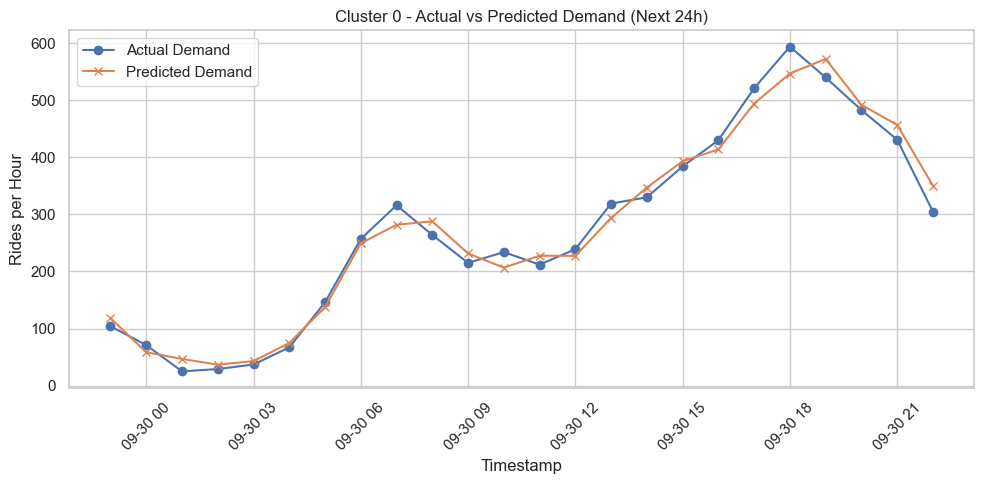

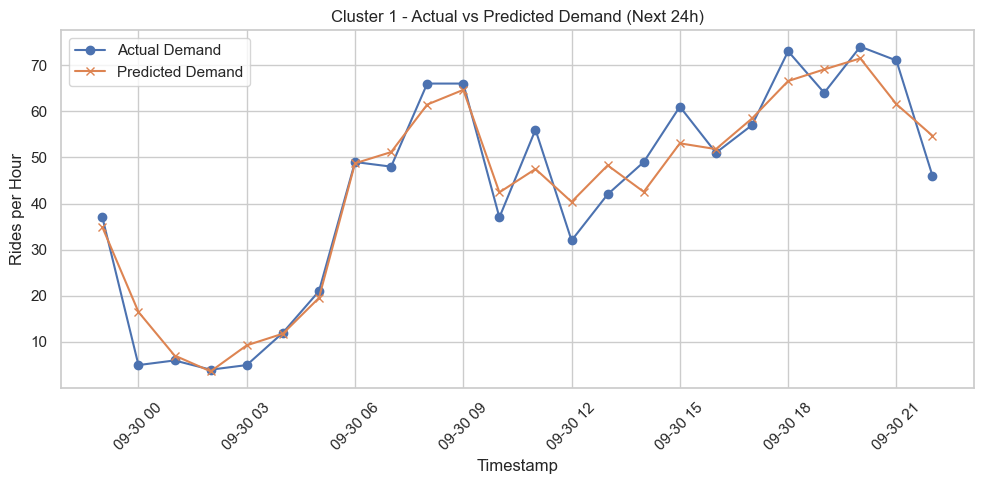

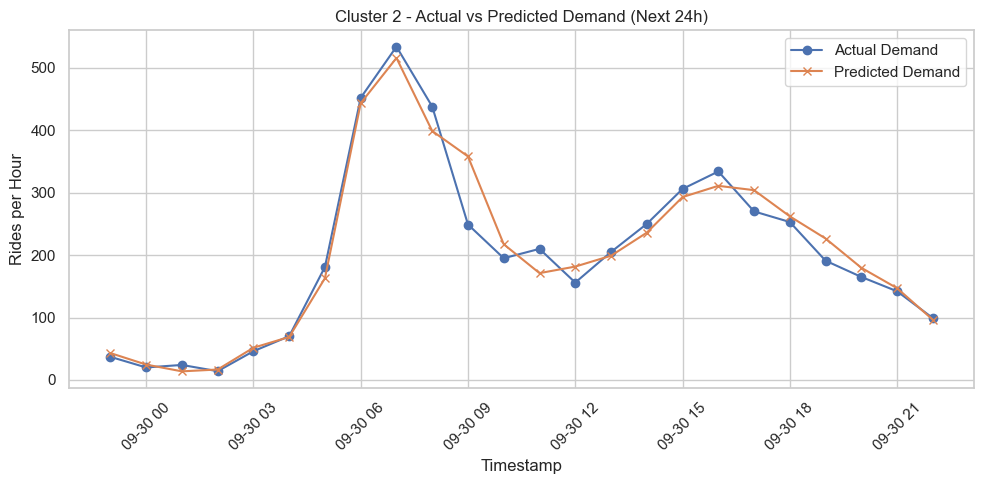

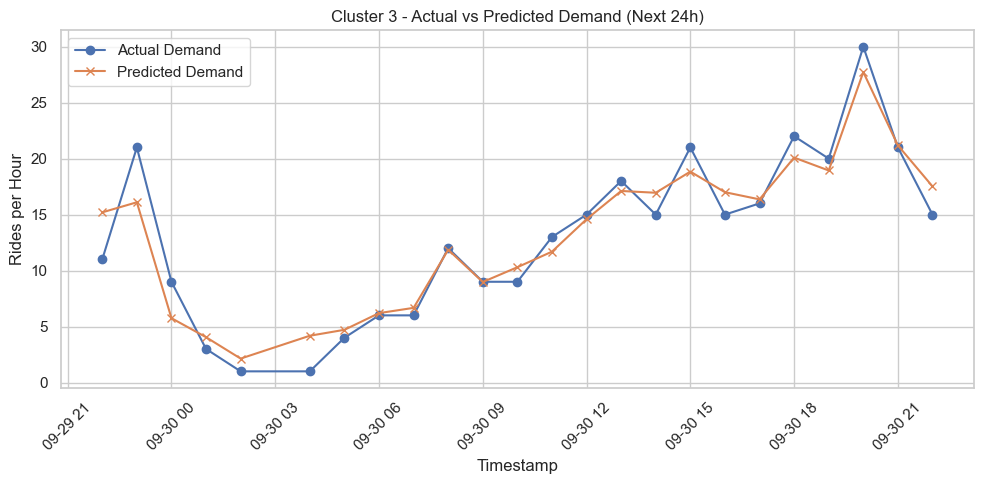

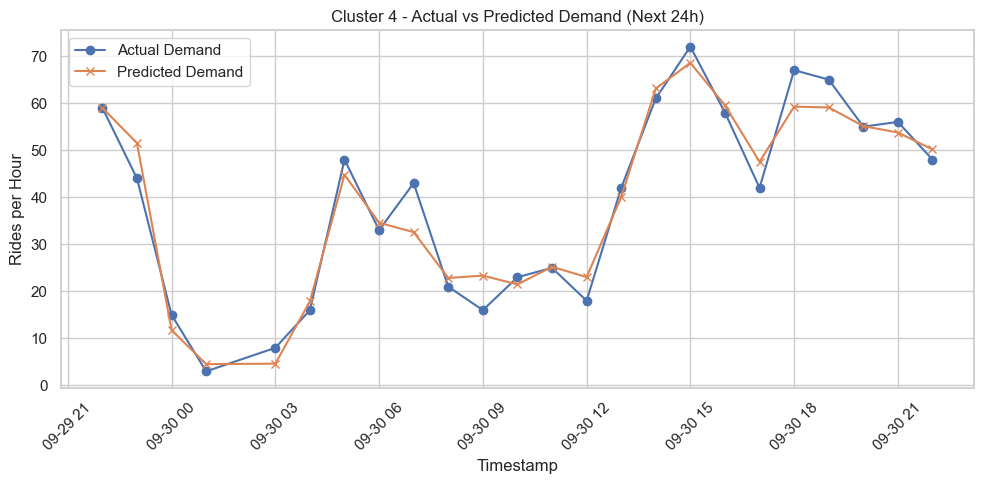

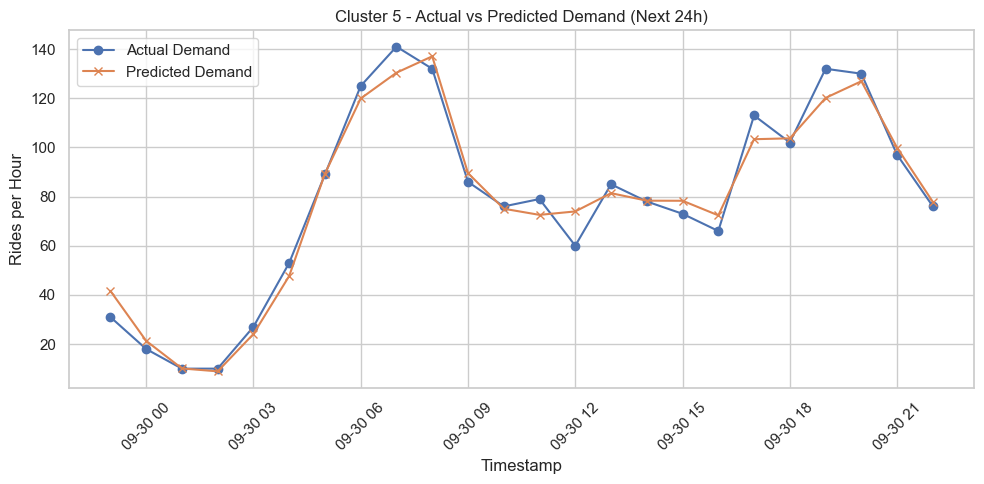

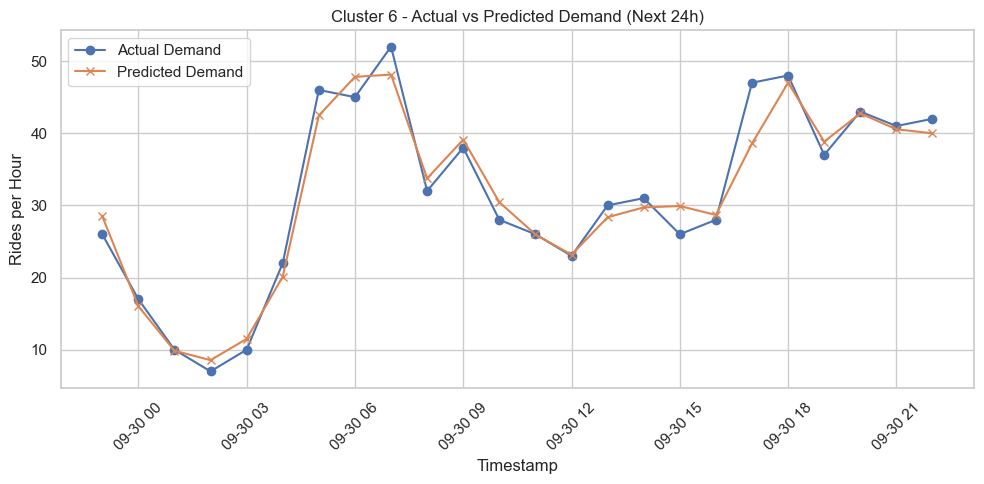

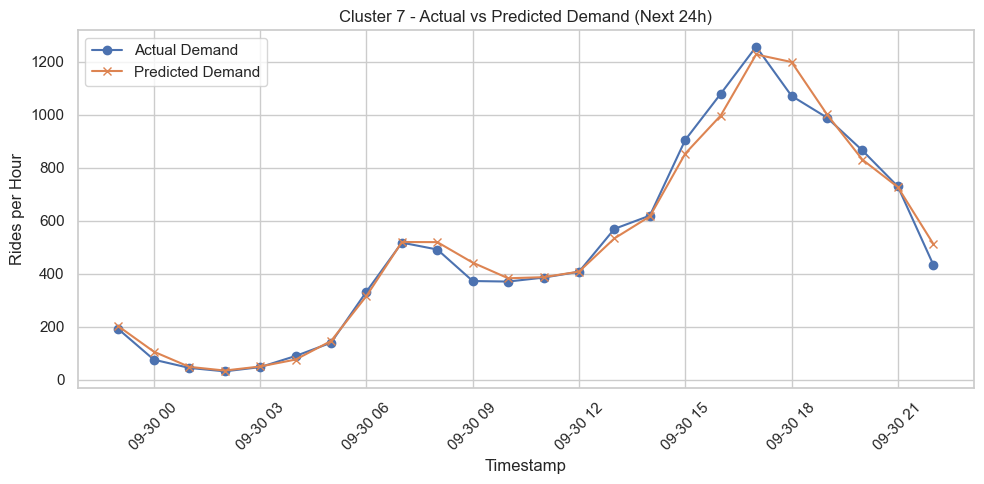

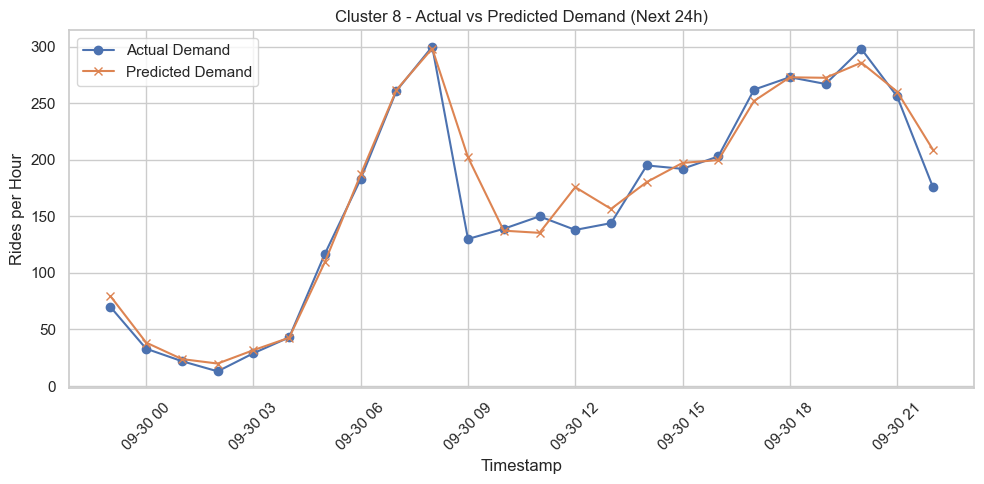

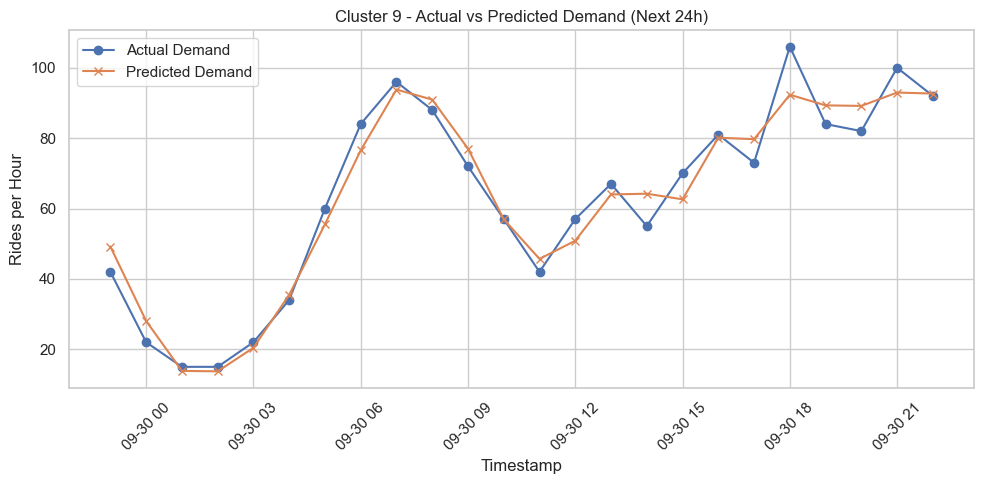

Final summary DataFrame with loaded best models for the 10 clusters:


,Cluster,Test_RMSE,Test_Daily_Demand_Error_%
0,0,22.68,0.54
1,1,5.59,0.42
2,2,29.38,1.68
3,3,2.03,0.36
4,4,4.32,0.50
5,5,6.18,0.28
6,6,2.59,0.69
7,7,42.21,1.00
8,8,19.26,3.50
9,9,5.67,0.07


In [160]:
# Defining the feature columns
feature_cols = ['hour', 'dayofweek', 'month', 'is_weekend', '_is_holiday',
                'lag_1', 'lag_2', 'lag_3',
                'rolling_mean_3', 'rolling_std_6']

# Setting the training window to 4 weeks
window_size_hours = 4 * 7 * 24  

# Setting the forecast window to the next 24 hours
forecast_horizon_hours = 24     

all_results = []

for i in range(10):
    cluster_df = globals()[f'cluster_{i}'].copy()

    if len(cluster_df) < window_size_hours + forecast_horizon_hours:
        print(f"Cluster {i} does not have enough data.")
        continue

    # Load the saved model
    model_path = f'/Users/sandragedig/Documents/Dokumente/Data_Science/Semester_6/Model_Engineering_Case_Study/public_transport_forecast/models/best_rf_cluster_{i}.joblib'
    model = joblib.load(model_path)

    # Prepare training and testing slices
    train = cluster_df.iloc[-(window_size_hours + forecast_horizon_hours):-forecast_horizon_hours]
    test = cluster_df.iloc[-forecast_horizon_hours:]

    X_train = train[feature_cols]
    y_train = train['rides_per_hour']

    X_test = test[feature_cols]
    y_test = test['rides_per_hour']

    # Predict on test set with loaded model
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    pct_error_test = abs(y_test.sum() - y_pred_test.sum()) / y_test.sum() * 100 if y_test.sum() > 0 else np.nan

    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    pct_error_train = abs(y_train.sum() - model.predict(X_train).sum()) / y_train.sum() * 100 if y_train.sum() > 0 else np.nan

    # Store results
    all_results.append({
        'Cluster': i,
        'Test_RMSE': rmse_test,
        'Test_Daily_Demand_Error_%': pct_error_test,
    })

    # Plot actual vs predicted demand
    plt.figure(figsize=(10,5))
    plt.plot(test['messagetimestamp'], y_test, label='Actual Demand', marker='o')
    plt.plot(test['messagetimestamp'], y_pred_test, label='Predicted Demand', marker='x')
    plt.title(f'Cluster {i} - Actual vs Predicted Demand (Next 24h)')
    plt.xlabel('Timestamp')
    plt.ylabel('Rides per Hour')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Create DataFrame from results
final_summary_df = pd.DataFrame(all_results).round(2)

print("Final summary DataFrame with loaded best models for the 10 clusters:")
final_summary_df

### Key Findings:
- Each cluster’s model was optimized to minimize RMSE and training error, selecting the best-performing model for accurate predictions.
- Despite the large and complex dataset, the deviations (errors) across all clusters are very small.
- This low error level indicates that the models provide sufficiently precise forecasts for taxi trip demand.
- Cluster 3 shows the best results with the lowest RMSE (2.03) and minimal daily demand error (0.36%), exemplifying highly reliable predictions.
- Other clusters like 1, 5, 6, and 9 also achieved low errors, demonstrating robust performance across different demand patterns.
- Some clusters (0, 2, 4, 7, 8) exhibit higher errors, reflecting more challenging or volatile data, but errors remain acceptable for practical use.
- Overall, the models are well-suited for forecasting taxi trips, balancing complexity and prediction accuracy effectively, even on a massive dataset.